In [1]:
import pandas as pd
import numpy as np
import json
import datetime as dt
from datetime import datetime, date, time,timedelta
import pandas as pd
from csv import DictWriter
import urllib
import re,datetime
import os
import time
from os import walk
import re
import gc
from tqdm.notebook import tqdm, trange
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)


#############
#INPUTS
#############

delta = 15

index = "BANKNIFTY"
index_file_path = "D:\Correlation Backtest Data 2016-23\Correlation 2-23 to 3-23 data\Input Files\Index\BANKNIFTY.csv"

stfolder = "D:/Correlation Backtest Data 2016-23/Correlation 2-23 to 3-23 data/Input Files/Stocks"
    
wgt_lot_path = "D:\Correlation Backtest Data 2016-23\Correlation 6-16 to 1-23 data\Input Files\Others\BN Mcap & includeok - Copy - Copy.csv"

direc = r"D:/Correlation Backtest Data 2016-23/Correlation 2-23 to 3-23 data/Working Files/Delta_" + str(delta)

output_path = r"D:/Correlation Backtest Data 2016-23/Correlation 2-23 to 3-23 data/Output Files/Delta_" + str(delta)

index_lotsize = 1

initial_equity = 100000


#########################
#Creating Stock List
#########################

filename = next(walk(stfolder), (None, None, []))[2]  # [] if no file
stock_list_path = []
for i in filename:
    temp = stfolder +"/"+ i
    stock_list_path.append(temp)

    
stock_list = []
for i in stock_list_path:
    stock_list.append(i.replace(".csv","").replace(stfolder + "/",""))
print(stock_list)
    
######################################    
#Creating weight and lot dictionary
######################################

"""wgtlot_df = pd.read_csv(wgt_lot_path)
wgtlot_dict = wgtlot_df.set_index('Symbol').T.to_dict('list')
print(wgtlot_dict)
symbols = list(wgtlot_dict.keys())"""

### Now adding Columns for weights below

######################################

lookback_period = 15
std_dev = 2

####################
#EXPIRY DATES
####################
symbols = stock_list.copy()
symbols.append(index)

exp_file_path = "D:\Correlation Backtest Data 2016-23\Correlation 6-16 to 1-23 data\Input Files\Others\MonthlyExpiry.csv"

exp_df = pd.read_csv(exp_file_path,parse_dates = ["curr_exp_date","Date"],dayfirst =True,usecols = ["curr_exp_date","Date"])
#exp_df.rename({'curr_date': 'Date'}, axis=1, inplace=True)

['AUBANK', 'AXISBANK', 'BANDHANBNK', 'BANKBARODA', 'CANBK', 'FEDERALBNK', 'HDFCBANK', 'ICICIBANK', 'IDFCFIRSTB', 'INDUSINDBK', 'KOTAKBANK', 'PNB', 'RBLBANK', 'SBIN']


### Separating Current Month, Next Month and Far Month data

In [2]:
idx = pd.read_csv(index_file_path,parse_dates = ["Date"],dayfirst = True)
idx = idx[idx['Date'] >= pd.to_datetime('1-1-2021', format = '%d-%m-%Y', dayfirst = True)]
#df1 = idx[idx['Ticker'].str.endswith('-I')]
#df2 = idx[idx['Ticker'].str.endswith('-II')]
#df3 = idx[idx['Ticker'].str.endswith('-III')]

################################################# Specific to 2023 data below Banknifty format


df1 = idx[idx['Ticker'].map(lambda x: str(x)[:-7]).str.endswith('-I')]
df2 = idx[idx['Ticker'].map(lambda x: str(x)[:-7]).str.startswith('-II')]
df3 = idx[idx['Ticker'].map(lambda x: str(x)[:-7]).str.startswith('-III')]



#################################################

index_file_path = direc + "/BANKNIFTY.csv"

df1.to_csv(index_file_path)
df2.to_csv(index_file_path.replace("BANKNIFTY","BANKNIFTY-II"))
df3.to_csv(index_file_path.replace("BANKNIFTY","BANKNIFTY-III"))

print(idx.shape[0])
print(df1.shape[0]+df2.shape[0]+df3.shape[0])
    
for i in stock_list:
    df = pd.read_csv(stfolder + '/' + i + ".csv",parse_dates = ["Date"],dayfirst = True)
    df = df[df['Date'] >= pd.to_datetime('1-1-2021', format = '%d-%m-%Y', dayfirst = True)]
    df1 = df[df['Ticker'].str.endswith('-I')]
    df2 = df[df['Ticker'].str.endswith('-II')]
    df3 = df[df['Ticker'].str.endswith('-III')]
    
    path = direc + '/' + i + ".csv"
    
    df1.to_csv(path)
    df2.to_csv(path.replace(i,i+"-II"))
    df3.to_csv(path.replace(i,i+"-III"))
    
    print(df.shape[0])
    print(df1.shape[0]+df2.shape[0]+df3.shape[0])

stfolder = direc
print(index_file_path)

9471
5280
1084
1084
2366
2366
1464
1464
2294
2294
1846
1846
1924
1924
3065
3065
2546
2546
1711
1711
1821
1821
1858
1858
1810
1810
1747
1747
4048
4048
D:/Correlation Backtest Data 2016-23/Correlation 2-23 to 3-23 data/Working Files/Delta_15/BANKNIFTY.csv


In [3]:
idx = pd.read_csv(index_file_path,usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close", "IV", 'Delta', f'Delta_{delta}_Strike'],parse_dates = ["Date"])

idx = pd.merge(idx, exp_df, on = 'Date', how = 'left')

idx_ce = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "CE")].add_suffix("_CE")
idx_pe = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "PE")].add_suffix("_PE")


final = idx_ce.merge(idx_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])

final = final.T.drop_duplicates().T  #Drop Duplicates Columns

final = final.add_prefix(index +"_")
final = final.sort_values(by=index +"_"+'Date_CE')

final.to_csv(output_path+"/check-1data.csv")

d1 = dt.datetime.strptime('2021-09-28','%Y-%m-%d')
d2 = dt.datetime.strptime('2021-11-04','%Y-%m-%d')
d3 = dt.datetime.strptime('2021-12-21','%Y-%m-%d')

final.drop(final[(final['BANKNIFTY_Date_CE'] == d1) | (final['BANKNIFTY_Date_CE'] == d2) | (final['BANKNIFTY_Date_CE'] == d3)].index, inplace = True)
final.to_csv(output_path+"/check-11111data.csv")
display(final)

for i in stock_list:
    print(i)
    df1 = pd.read_csv(stfolder+ '/' + i + ".csv",parse_dates = ["Date"],usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"])

    df1 = pd.merge(df1, exp_df, on = 'Date', how = 'left')
    
    
    df_ce = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "CE")].add_suffix("_CE")
    df_pe = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "PE")].add_suffix("_PE")
    print(df1.shape[0], df_ce.shape[0], df_pe.shape[0])
    temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
    #temp = temp.T.drop_duplicates().T
    temp = temp.add_prefix(i +"_")
    
    
    final = final.merge(temp,how='left',left_on=index + '_Date_CE', right_on= i + '_Date_CE')
    
#final = final.T.drop_duplicates().T
curr_final_df = final.copy()
u = curr_final_df.select_dtypes(exclude=['datetime'])
curr_final_df[u.columns] = u.fillna(0)

curr_final_df.to_csv(output_path+"/check-2data.csv")

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE
0,2023-01-27,BANKNIFTYMONTHLY-I43000CE,168.8,43000.0,0.205979,0.148207,40345.3008,2023-02-23,BANKNIFTYMONTHLY-I38000PE,245.85,38000.0,0.24857,-0.16476
1,2023-01-30,BANKNIFTYMONTHLY-I43100CE,178.85,43100.0,0.226674,0.150722,40387.4492,2023-02-23,BANKNIFTYMONTHLY-I38000PE,248.65,38000.0,0.266328,-0.164742
2,2023-01-31,BANKNIFTYMONTHLY-I43300CE,166.5,43300.0,0.221257,0.14665,40655.0508,2023-02-23,BANKNIFTYMONTHLY-I38400PE,198.3,38400.0,0.24014,-0.151586
3,2023-02-01,BANKNIFTYMONTHLY-I42800CE,147.35,42800.0,0.197883,0.148093,40513.0,2023-02-23,BANKNIFTYMONTHLY-I38000PE,235.0,38000.0,0.280089,-0.156231
4,2023-02-02,BANKNIFTYMONTHLY-I42800CE,150.05,42800.0,0.193715,0.155201,40669.3008,2023-02-23,BANKNIFTYMONTHLY-I38400PE,186.25,38400.0,0.246177,-0.146592
5,2023-02-03,BANKNIFTYMONTHLY-I43300CE,116.85,43300.0,0.159755,0.148198,41499.6992,2023-02-23,BANKNIFTYMONTHLY-I39500PE,171.25,39500.0,0.220857,-0.150426
6,2023-02-06,BANKNIFTYMONTHLY-I43100CE,125.75,43100.0,0.174127,0.157006,41374.6484,2023-02-23,BANKNIFTYMONTHLY-I39400PE,162.85,39400.0,0.233006,-0.148157
7,2023-02-07,BANKNIFTYMONTHLY-I43200CE,102.9,43200.0,0.166926,0.141138,41490.9492,2023-02-23,BANKNIFTYMONTHLY-I39700PE,146.05,39700.0,0.216155,-0.147669
8,2023-02-08,BANKNIFTYMONTHLY-I43000CE,108.0,43000.0,0.157418,0.157628,41537.6484,2023-02-23,BANKNIFTYMONTHLY-I39900PE,135.95,39900.0,0.204911,-0.149419
9,2023-02-09,BANKNIFTYMONTHLY-I43000CE,89.25,43000.0,0.152192,0.142657,41554.3008,2023-02-23,BANKNIFTYMONTHLY-I40200PE,114.95,40200.0,0.176778,-0.151485


AUBANK
914 33 33
AXISBANK
1719 33 33
BANDHANBNK
1117 33 33
BANKBARODA
1743 33 33
CANBK
1458 33 33
FEDERALBNK
1614 33 33
HDFCBANK
2383 33 33
ICICIBANK
1719 33 33
IDFCFIRSTB
1220 33 33
INDUSINDBK
1370 33 33
KOTAKBANK
1355 33 33
PNB
1318 33 33
RBLBANK
1416 33 33
SBIN
2690 33 33


In [4]:
idx = pd.read_csv(index_file_path.replace("BANKNIFTY","BANKNIFTY-II"),usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"],parse_dates = ["Date"])


idx = pd.merge(idx, exp_df, on = 'Date', how = 'left')


idx_ce = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "CE")].add_suffix("_CE")
idx_pe = idx[(idx["Strike"] == idx[f"Delta_{delta}_Strike"]) & (idx["Option_Type"] == "PE")].add_suffix("_PE")


final = idx_ce.merge(idx_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])

final = final.T.drop_duplicates().T  #Drop Duplicates Columns

final = final.add_prefix(index +"_")
final = final.sort_values(by=index +"_"+'Date_CE')
final.to_csv(output_path+"/check-3data.csv")

for i in stock_list:
    print(i)
    path  = stfolder+ '/' + i + ".csv"
    df1 = pd.read_csv(path.replace(i,i+"-II"),parse_dates = ["Date"],usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close","EQ_Close","IV", 'Delta', f"Delta_{delta}_Strike"])
    df1 = pd.merge(df1, exp_df, on = 'Date', how = 'left')

    
    df_ce = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "CE")].add_suffix("_CE")
    df_pe = df1[(df1["Strike"] == df1[f"Delta_{delta}_Strike"]) & (df1["Option_Type"] == "PE")].add_suffix("_PE")
    
    
    temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
    #temp = temp.T.drop_duplicates().T
    temp = temp.add_prefix(i +"_")
    final = final.merge(temp,how='left',left_on=index + '_Date_CE', right_on= i + '_Date_CE')



    

#final = final.T.drop_duplicates().T
next_final_df = final.copy()

next_final_df.to_csv(output_path+"/check-4.0data.csv")

u = next_final_df.select_dtypes(exclude=['datetime'])
next_final_df[u.columns] = u.fillna(0)

next_final_df.to_csv(output_path+"/check-4data.csv")

AUBANK
AXISBANK
BANDHANBNK
BANKBARODA
CANBK
FEDERALBNK
HDFCBANK
ICICIBANK
IDFCFIRSTB
INDUSINDBK
KOTAKBANK
PNB
RBLBANK
SBIN


In [5]:
replacedf = curr_final_df[curr_final_df[index + "_Date_CE"] == curr_final_df[index + "_curr_exp_date_CE"]]
restdf = curr_final_df[~(curr_final_df[index + "_Date_CE"] == curr_final_df[index + "_curr_exp_date_CE"])]

nextdf = next_final_df[next_final_df[index + "_Date_CE"] == next_final_df[index + "_curr_exp_date_CE"]]


for i in symbols:
    if nextdf.shape[0] == replacedf.shape[0]:
        replacedf[i + "_IV_CE"] = nextdf[i + "_IV_CE"]
        replacedf[i + "_IV_PE"] = nextdf[i + "_IV_PE"]
        replacedf[i + '_Strike_CE'] = nextdf[i + '_Strike_CE']
        if delta!=50:
            replacedf[i + '_Strike_PE'] = nextdf[i + '_Strike_PE']
        else:
            replacedf[i + '_Strike_PE'] = nextdf[i + '_Strike_CE']
        replacedf[i + '_Delta_CE'] = nextdf[i + '_Delta_CE']
        replacedf[i + '_Delta_PE'] = nextdf[i + '_Delta_PE']
        
        print("EXCHANGE DONE")
    else:
        print("Entries Missing Error")
        break

final = restdf.append(replacedf).sort_values(by=[index+"_Date_CE"]).reset_index().drop(columns = ["index"])


Entries Missing Error


In [6]:
final.to_csv(output_path+"\Part-1data.csv")
data = pd.read_csv(output_path+"\Part-1data.csv",parse_dates = [index + "_Date_CE"],dayfirst = True)


In [7]:
#Adding Avg IV Columns
data[index + "_Avg IV"] = (data[index + "_IV_CE"] + data[index + "_IV_PE"])/2
curr_final_df[index + "_Avg IV"] = data[index + "_Avg IV"]

data[index + "_Avg Delta"] = (data[index + "_Delta_CE"] + (- data[index + "_Delta_PE"]))/2
curr_final_df[index + "_Avg Delta"] = data[index + "_Avg Delta"]

for i in stock_list:
    data[i + "_Avg IV"] = (data[i + "_IV_CE"] + data[i + "_IV_PE"])/2
    curr_final_df[i + "_Avg IV"] = data[i + "_Avg IV"]
    
    data[i + "_Avg Delta"] = (data[i + "_Delta_CE"] + (- data[i + "_Delta_PE"]))/2
    curr_final_df[i + "_Avg Delta"] = data[i + "_Avg Delta"]
    
    
data = curr_final_df.copy()

# Adding Weights Columns

In [8]:
weight = pd.read_csv(wgt_lot_path,parse_dates = ["date"],dayfirst = True,usecols = ["Security Symbol","Weightage","date","includeok","Lotsize"])

In [9]:
grp = weight.groupby("Security Symbol")
data[index + "_OG_Weight"] = 100
for i in stock_list:
    d1 = grp.get_group(i)
    d1[i + "_OG_Weight"] = d1["Weightage"]
    d1[index+ "_Date_CE"] = d1["date"]
    data = pd.merge(data,d1[[index+ "_Date_CE",i + "_OG_Weight"]],on= index+ "_Date_CE", how='left')

if data.isnull().sum().sum() != 0:
    print(data.isnull().sum().sum())
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")



66
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR


### Adding Final Weight Columns

In [10]:
filter_col = [col for col in data if col.endswith('Weight')]
filter_col.remove(index + "_OG_Weight")

data["actual_wgt_sum"] = data[filter_col].sum(axis=1)

for i in stock_list:
    data[i + "_Final_Weight"] = data[i + "_OG_Weight"]/data["actual_wgt_sum"]
data[index + "_Final_Weight"] = 1

In [11]:
u = data.select_dtypes(exclude=['datetime'])
data[u.columns] = u.fillna(0)



In [12]:
data['index_iv'] = data[index +'_Avg IV']*100
data['stock_iv']  = 0


data['index_delta'] = data[index +'_Avg Delta']*100
data['stock_delta']  = 0


for i in stock_list:
    data['stock_iv'] += data[i + '_Avg IV']*data[i + "_Final_Weight"] 
    
    data['stock_delta'] += data[i + '_Avg Delta']*data[i + "_Final_Weight"]
    
data['implied_correl'] = (data['index_iv']/data['stock_iv'])

print(data.isnull().sum().sum())

0


In [13]:
data['avg'] = data['implied_correl'].rolling(lookback_period).mean()
df = data.copy()

df.to_csv(output_path+'/impliedratio.csv')

In [14]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * std_dev # Calculate top band
    bollinger_down = sma - std * std_dev # Calculate bottom band
    return bollinger_up, bollinger_down

df['bollinger_up'], df['bollinger_down'] = get_bollinger_bands(df['implied_correl'], lookback_period)

df['sma'] = get_sma(df['implied_correl'], lookback_period)
df['long_avg'] = df['implied_correl'].mean()


#print(df['bollinger_up'])
#print(df['bollinger_down'])
#print(df['long_avg'])
#print(df['sma'])

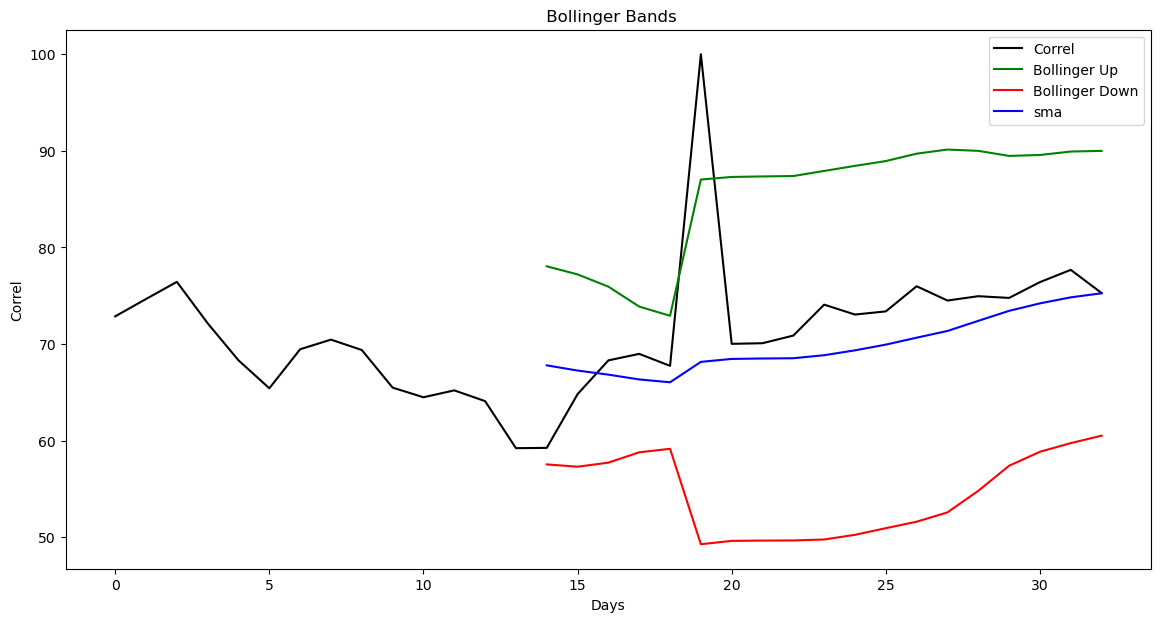

In [15]:
import matplotlib.pyplot as plt

df.head()

fig = plt.figure(figsize=(14,7))
plt.title(' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Correl')
plt.plot(df['implied_correl'], label='Correl', c = 'black')
plt.plot(df['bollinger_up'], label='Bollinger Up', c='g')
plt.plot(df['bollinger_down'], label='Bollinger Down', c='r')
plt.plot(df['sma'], label='sma', c='b')

plt.legend()
plt.show()

In [16]:
df.to_csv(output_path+"\series.csv")

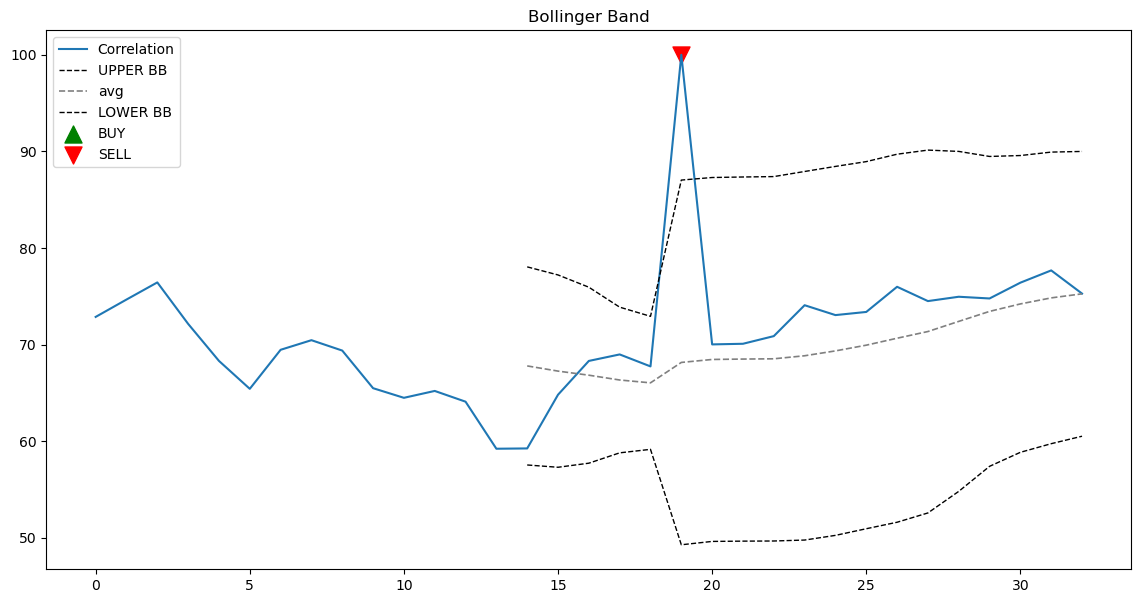

In [17]:
def implement_bb_strategy(data, lower_bb, upper_bb, avg):
    entry_ratio = []
    exit_ratio = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if(i==0):
            if data[i] < lower_bb[i]:
                if signal != 1:
                    entry_ratio.append(data[i])
                    exit_ratio.append(np.nan)
                    signal = 1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(0)
            elif data[i] > upper_bb[i]:
                if signal != -1:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(data[i])
                    signal = -1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(0)
            else:
                entry_ratio.append(np.nan)
                exit_ratio.append(np.nan)
                bb_signal.append(0)
        else:
            if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
                if signal != 1:
                    entry_ratio.append(data[i])
                    exit_ratio.append(np.nan)
                    signal = 1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])

            elif data[i-1] > avg[i-1] and data[i] < avg[i]:
                if signal != 0:
                    entry_ratio.append(data[i])
                    exit_ratio.append(np.nan)
                    signal = 0
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])                
            
            elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
                if signal != -1:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(data[i])
                    signal = -1
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])

            elif data[i-1] < avg[i-1] and data[i] > avg[i]:
                if signal != 0:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(data[i])
                    signal = 0
                    bb_signal.append(signal)
                else:
                    entry_ratio.append(np.nan)
                    exit_ratio.append(np.nan)
                    bb_signal.append(bb_signal[i-1])

            else:
                entry_ratio.append(np.nan)
                exit_ratio.append(np.nan)
                bb_signal.append(bb_signal[i-1])

    return entry_ratio, exit_ratio, bb_signal

df['entry_ratio'], df['exit_ratio'], df['bb_signal'] = implement_bb_strategy(df['implied_correl'], df['bollinger_down'], df['bollinger_up'], df['avg'])

fig = plt.figure(figsize=(14,7))


df['implied_correl'].plot(label = 'Correlation', alpha = 1)
df['bollinger_up'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df['avg'].plot(label = 'avg', linestyle = '--', linewidth = 1.2, color = 'grey')
df['bollinger_down'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df.index, df['entry_ratio'], marker = '^', color = 'green', label = 'BUY', s = 150)
plt.scatter(df.index, df['exit_ratio'], marker = 'v', color = 'red', label = 'SELL', s = 150)
plt.title('Bollinger Band')
plt.legend(loc = 'upper left')
plt.show()


In [18]:
df1 = df.copy()

In [19]:
df1['dispersion_entry'] = False #(df1['bb_signal'] == -1) & (df1['exit_ratio'] > 0)  & (df1['entry_ratio'].isna() == True)
df1['dispersion_exit'] = False #(df1['bb_signal'] == 0) & (df1['entry_ratio'] > 0) & (df1['entry_ratio'].isna() == False)

df1['correlation_entry'] = np.nan
df1['correlation_exit'] = np.nan
df1['bb_signal'] = np.nan

#df1['correlation_entry'] = (df1['bb_signal'] == 1) & (df1['entry_ratio'] > 0)  & (df1['exit_ratio'].isna() == True)
#df1['correlation_exit'] = (df1['bb_signal'] == 0)  & (df1['exit_ratio'] > 0)  & (df1['exit_ratio'].isna() == False):

df1['bb_signal'] = df1.apply(lambda x: 0 if x['BANKNIFTY_Date_CE']==x['BANKNIFTY_curr_exp_date_CE'] else 1, axis=1)



for i in range(len(df1)):
    if(i==0):
        df1.loc[i,'correlation_entry'] = True
        df1.loc[i,'correlation_exit'] = False
    elif (df1.loc[i-1, 'BANKNIFTY_Date_CE'] == df1.loc[i-1, 'BANKNIFTY_curr_exp_date_CE']):  
        df1.loc[i,'correlation_entry'] = True
        df1.loc[i,'correlation_exit'] = False
    elif (df1.loc[i,'BANKNIFTY_Date_CE'] == df1.loc[i,'BANKNIFTY_curr_exp_date_CE']):
        df1.loc[i,'correlation_entry'] = False
        df1.loc[i,'correlation_exit'] = True
    else:
        df1.loc[i,'correlation_entry'] = False
        df1.loc[i,'correlation_exit'] = False

        
    

In [20]:
df2 = df1.copy()


df2.to_csv(output_path + '//' + 'with entry exit signals_all data.csv')

In [21]:
# getting all the rows with entry or exit signals
df = df2[ (df2["dispersion_entry"] == True) | (df2["correlation_exit"] == True) | 
              (df2["dispersion_exit"] == True) | (df2["correlation_entry"] == True) ].reset_index()

df.to_csv(output_path + '//' + 'with entry exit signals.csv')

In [22]:
trades = []

for i in df.index[:-1]:
    if df["bb_signal"][i] == -1:
        strikes = {}
        strikes[index + '_Strike_CE'] = df[index + "_Strike_CE"][i]
        if delta != 50: 
            strikes[index + '_Strike_PE'] = df[index + "_Strike_PE"][i]
        else:
            strikes[index + '_Strike_PE'] = df[index + "_Strike_CE"][i]
            
        for j in stock_list:
            strikes[j + '_Strike_CE'] = df[j +"_Strike_CE"][i]
            if delta != 50: 
                strikes[j + '_Strike_PE'] = df[j + "_Strike_PE"][i]
            else:
                strikes[j + '_Strike_PE'] = df[j + "_Strike_CE"][i]
        trades.append( 
                        { 
                          "entry_date": df[index + "_Date_CE"][i],
                          "exit_date" : df[index + "_Date_CE"][i+1],
                          "expiry_date" : df[index+"_curr_exp_date_CE"][i],
                          "type_of_trade": "SILS",
                          "strike" : strikes,
                          "entry_ratio" : df["exit_ratio"][i],
                          "exit_ratio" : df["entry_ratio"][i+1]
                        }
                      )
                            
    if df["bb_signal"][i] == 1:
            strikes = {}
            strikes[index + '_Strike_CE'] = df[index + "_Strike_CE"][i]
            if delta != 50:
                strikes[index + '_Strike_PE'] = df[index + "_Strike_PE"][i]
            else:
                strikes[index + '_Strike_PE'] = df[index + "_Strike_CE"][i]
            for j in stock_list:
                strikes[j + '_Strike_CE'] = df[j + "_Strike_CE"][i]
                if delta != 50: 
                    strikes[j + '_Strike_PE'] = df[j + "_Strike_PE"][i]
                else:
                    strikes[j + '_Strike_PE'] = df[j + "_Strike_CE"][i]
            trades.append( 
                            { 
                              "entry_date": df[index + "_Date_CE"][i],
                              "exit_date" : df[index + "_Date_CE"][i+1],
                              "expiry_date" : df[index+"_curr_exp_date_CE"][i],
                              "type_of_trade": "LISS",
                              "strike" : strikes,
                              "entry_ratio" : df["entry_ratio"][i],
                              "exit_ratio" : df["exit_ratio"][i+1]
                            }
                          )

In [23]:
for i in tqdm(trades):
    date1 = i["entry_date"]
    date2 = i["exit_date"]
    expiry = i["expiry_date"]
    print(date1)
    print(date2)
    
    if expiry == date1:
        df = pd.read_csv(index_file_path,parse_dates = ["Date"])
        nextdf = pd.read_csv(index_file_path.replace(index,index+"-II"),parse_dates = ["Date"])
        
        df = df[(df["Date"] > date1) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][index + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][index + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]
        nextdf = nextdf[(nextdf["Date"] == expiry) & 
                        (((nextdf["Strike"] == i["strike"][index + '_Strike_CE']) & (nextdf['Option_Type'] == 'CE')) |
                        ((nextdf['Strike'] == i['strike'][index + '_Strike_PE']) & (nextdf['Option_Type'] == 'PE')))]
        
        nextdf = nextdf.append(df)
        nextdf = pd.merge(nextdf, exp_df, on = 'Date', how = 'left')
        df_dict = {}
        df_dict[index] = nextdf
        for j in stock_list:
            path = stfolder + '/' + j + ".csv"
            df = pd.read_csv(path,parse_dates = ["Date"])
            nextdf = pd.read_csv(path.replace(j,j+"-II"),parse_dates = ["Date"])
                        
            df = df[(df["Date"] > date1) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][j + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][j + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]   
            
            
            nextdf = nextdf[(nextdf["Date"] == expiry) & 
                        (((nextdf["Strike"] == i["strike"][index + '_Strike_CE']) & (nextdf['Option_Type'] == 'CE')) |
                        ((nextdf['Strike'] == i['strike'][index + '_Strike_PE']) & (nextdf['Option_Type'] == 'PE')))]
            nextdf = nextdf.append(df)
            nextdf = pd.merge(nextdf, exp_df, on = 'Date', how = 'left')
            df_dict[j] = nextdf
        i["dataframes"] = df_dict
    
    else:
        df = pd.read_csv(index_file_path,parse_dates = ["Date"])
        df = df[(df["Date"] >= date1) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][index + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][index + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]
        df = pd.merge(df, exp_df, on = 'Date', how = 'left')
        df_dict = {}
        df_dict[index] = df
        
        for j in stock_list:
            df = pd.read_csv(stfolder + '/' + j + ".csv",parse_dates = ["Date"])    
            df = df[(df["Date"] >= date1) & (df["Date"] <= date2) &
                (((df["Strike"] == i["strike"][j + '_Strike_CE']) & (df["Option_Type"] == 'CE')) |
                 ((df["Strike"] == i["strike"][j + '_Strike_PE']) & (df["Option_Type"] == 'PE')))]
                
            df = pd.merge(df, exp_df, on = 'Date', how = 'left')
            df_dict[j] = df
        i["dataframes"] = df_dict

  0%|          | 0/2 [00:00<?, ?it/s]

2023-01-27 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-03-15 00:00:00


In [24]:
# check what does trades[i]['dataframes'] contains
for i in trades:
    print(i["dataframes"]['BANKNIFTY'].columns)

Index(['Unnamed: 0', 'Date', 'Ticker', 'OPT_Open', 'OPT_High', 'OPT_Low', 'OPT_Close',
       'OPT_Contracts', 'OPT_OI', 'Strike', 'Option_Type', 'Expiry_Date', 'IV', 'Delta', 'Theta',
       'Gamma', 'Vega', 'EQ_Open', 'EQ_High', 'EQ_Low', 'EQ_Close', 'At_The_Money',
       'Delta_5_Strike', 'Delta_10_Strike', 'Delta_15_Strike', 'Delta_20_Strike',
       'Delta_25_Strike', 'Delta_30_Strike', 'Delta_35_Strike', 'Delta_40_Strike',
       'Delta_45_Strike', 'Delta_50_Strike', 'Delta_55_Strike', 'Delta_60_Strike',
       'Delta_65_Strike', 'Delta_70_Strike', 'Delta_75_Strike', 'Delta_80_Strike',
       'Delta_85_Strike', 'Delta_90_Strike', 'Delta_95_Strike', 'curr_exp_date'],
      dtype='object')
Index(['Unnamed: 0', 'Date', 'Ticker', 'OPT_Open', 'OPT_High', 'OPT_Low', 'OPT_Close',
       'OPT_Contracts', 'OPT_OI', 'Strike', 'Option_Type', 'Expiry_Date', 'IV', 'Delta', 'Theta',
       'Gamma', 'Vega', 'EQ_Open', 'EQ_High', 'EQ_Low', 'EQ_Close', 'At_The_Money',
       'Delta_5_Strike', 'D

In [25]:
result = pd.DataFrame()
for trade_dict in trades:
    
    # df_dict contains options details for all the stocks and index for all the dates between entry and exit date
    df_dict = trade_dict["dataframes"]
    entry = trade_dict["entry_date"]
    exit = trade_dict["exit_date"]
    
    idx = df_dict[index][["Date","Ticker","OPT_Close","Strike","Option_Type","IV", 'Delta',"EQ_Close","curr_exp_date"]]
    
    idx_ce = idx[(idx["Option_Type"] == "CE")].add_suffix("_CE")
    idx_pe = idx[(idx["Option_Type"] == "PE")].add_suffix("_PE")
    
    
    
    final = idx_ce.merge(idx_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
    final = final.add_prefix(index +"_")

    for i in df_dict:
        if i == index:
            continue
        df1 = df_dict[i][["Date","Ticker","OPT_Close","Strike","Option_Type","IV", 'Delta', "EQ_Close","curr_exp_date"]]
        df_ce = df1[(df1["Option_Type"] == "CE")].add_suffix("_CE")
        df_pe = df1[(df1["Option_Type"] == "PE")].add_suffix("_PE")

        temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
        temp = temp.T.drop_duplicates().T
        temp = temp.add_prefix(i +"_")
        
        final = final.merge(temp,left_on=index + '_Date_CE' , right_on= i + '_Date_CE', how = 'left')
    final["Trade_Type"] = trade_dict["type_of_trade"]
    
    final.to_csv(output_path + '//' + 'final.csv', index=False)

    conditions = [
    (final[index + '_Date_CE'] == entry),
    (final[index + '_Date_CE'] == exit),
    (final[index + '_Date_CE'] != exit) & (final[index + '_Date_CE'] != entry)]

    # create a list of the values we want to assign for each condition
    values = ['F', 'L', 'M']

    # create a new column and use np.select to assign values to it using our lists as arguments
    final['D_marker'] = np.select(conditions, values)
    result = result.append(final)
        
#result = result.T.drop_duplicates().T
result.to_csv(output_path + '//' + 'final1.csv', index=False)
display(result)

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Date_PE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,...,KOTAKBANK_IV_CE,KOTAKBANK_Delta_CE,KOTAKBANK_EQ_Close_CE,KOTAKBANK_curr_exp_date_CE,KOTAKBANK_Ticker_PE,KOTAKBANK_OPT_Close_PE,KOTAKBANK_Strike_PE,KOTAKBANK_IV_PE,KOTAKBANK_Delta_PE,PNB_Date_CE,PNB_Ticker_CE,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,Trade_Type,D_marker
0,2023-01-27,BANKNIFTYMONTHLY-I43000CE,168.80,43000.0,0.205979,0.148207,40345.3008,2023-02-23,2023-01-27,BANKNIFTYMONTHLY-I38000PE,245.85,38000.0,0.248570,-0.164760,40345.3008,2023-02-23,2023-01-27,AUBANK660CE-I,4.25,660.0,0.307641,0.164693,603.95,2023-02-23,AUBANK540PE-I,7.6,540.0,0.478702,-0.170067,2023-01-27,AXISBANK950CE-I,5.0,950.0,0.275884,0.151753,873.75,2023-02-23,AXISBANK800PE-I,6.8,800.0,0.345454,-0.152535,2023-01-27,BANDHANBNK270CE-I,2.05,270,0.395265,0.158552,240.2,2023-02-23,...,0.255198,0.136092,1713.1,2023-02-23,KOTAKBANK1600PE-I,9.35,1600.0,0.259624,-0.145557,2023-01-27,PNB61CE-I,0.6,61.0,0.593295,0.151255,50.8,2023-02-23,PNB44PE-I,0.75,44.0,0.595164,-0.160525,2023-01-27,RBLBANK175CE-I,1.45,175.0,0.485959,0.14912,150.65,2023-02-23,RBLBANK132.5PE-I,1.5,132.5,0.480399,-0.140767,2023-01-27,SBIN610CE-I,4.25,610.0,0.396304,0.148191,539.95,2023-02-23,SBIN480PE-I,5.45,480.0,0.45589,-0.14877,LISS,F
1,2023-01-30,BANKNIFTYMONTHLY-I43000CE,184.00,43000.0,0.223079,0.156162,40387.4492,2023-02-23,2023-01-30,BANKNIFTYMONTHLY-I38000PE,248.65,38000.0,0.266328,-0.164742,40387.4492,2023-02-23,2023-01-30,AUBANK660CE-I,5.15,660.0,0.339761,0.185553,606.25,2023-02-23,AUBANK540PE-I,2.6,540.0,0.365748,-0.094017,2023-01-30,AXISBANK950CE-I,5.05,950.0,0.300031,0.150283,871.85,2023-02-23,AXISBANK800PE-I,5.85,800.0,0.341516,-0.143654,2023-01-30,BANDHANBNK270CE-I,1.9,270,0.392137,0.156108,241.9,2023-02-23,...,0.25291,0.142711,1726.25,2023-02-23,KOTAKBANK1600PE-I,10.0,1600.0,0.299745,-0.142327,2023-01-30,PNB61CE-I,0.45,61.0,0.582976,0.12692,50.7,2023-02-23,PNB44PE-I,0.65,44.0,0.592971,-0.1514,2023-01-30,RBLBANK175CE-I,1.15,175.0,0.494924,0.127898,149.8,2023-02-23,RBLBANK132.5PE-I,1.85,132.5,0.533032,-0.160874,2023-01-30,SBIN610CE-I,4.1,610.0,0.424619,0.143189,538.2,2023-02-23,SBIN480PE-I,5.35,480.0,0.471177,-0.150226,LISS,M
2,2023-01-31,BANKNIFTYMONTHLY-I43000CE,215.05,43000.0,0.222831,0.179076,40655.0508,2023-02-23,2023-01-31,BANKNIFTYMONTHLY-I38000PE,159.60,38000.0,0.249734,-0.123131,40655.0508,2023-02-23,2023-01-31,AUBANK660CE-I,6.35,660.0,0.315051,0.231371,618.9,2023-02-23,AUBANK540PE-I,1.55,540.0,0.369439,-0.060412,2023-01-31,AXISBANK950CE-I,4.6,950.0,0.298562,0.142241

In [26]:
###########REMOVE DATA HOLES 3 DAYS ###############
result = pd.read_csv(output_path + '//' + 'final1.csv', parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

d1 = dt.datetime.strptime('2021-09-28','%Y-%m-%d')
d2 = dt.datetime.strptime('2021-11-04','%Y-%m-%d')
d3 = dt.datetime.strptime('2021-12-21','%Y-%m-%d')

result = result.drop(result[(result['BANKNIFTY_Date_CE'] == d1) | (result['BANKNIFTY_Date_CE'] == d2) | (result['BANKNIFTY_Date_CE'] == d3)].index)
display(result)

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Date_PE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,...,KOTAKBANK_IV_CE,KOTAKBANK_Delta_CE,KOTAKBANK_EQ_Close_CE,KOTAKBANK_curr_exp_date_CE,KOTAKBANK_Ticker_PE,KOTAKBANK_OPT_Close_PE,KOTAKBANK_Strike_PE,KOTAKBANK_IV_PE,KOTAKBANK_Delta_PE,PNB_Date_CE,PNB_Ticker_CE,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,Trade_Type,D_marker
0,2023-01-27,BANKNIFTYMONTHLY-I43000CE,168.80,43000.0,0.205979,0.148207,40345.3008,2023-02-23,2023-01-27,BANKNIFTYMONTHLY-I38000PE,245.85,38000.0,0.248570,-0.164760,40345.3008,2023-02-23,2023-01-27,AUBANK660CE-I,4.25,660.0,0.307641,0.164693,603.95,2023-02-23,AUBANK540PE-I,7.60,540.0,0.478702,-0.170067,2023-01-27,AXISBANK950CE-I,5.00,950.0,0.275884,0.151753,873.75,2023-02-23,AXISBANK800PE-I,6.80,800.0,0.345454,-0.152535,2023-01-27,BANDHANBNK270CE-I,2.05,270,0.395265,0.158552,240.20,2023-02-23,...,0.255198,0.136092,1713.10,2023-02-23,KOTAKBANK1600PE-I,9.35,1600.0,0.259624,-0.145557,2023-01-27,PNB61CE-I,0.60,61.0,0.593295,0.151255,50.80,2023-02-23,PNB44PE-I,0.75,44.0,0.595164,-0.160525,2023-01-27,RBLBANK175CE-I,1.45,175.0,0.485959,0.149120,150.65,2023-02-23,RBLBANK132.5PE-I,1.50,132.5,0.480399,-0.140767,2023-01-27,SBIN610CE-I,4.25,610.0,0.396304,0.148191,539.95,2023-02-23,SBIN480PE-I,5.45,480.0,0.455890,-0.148770,LISS,F
1,2023-01-30,BANKNIFTYMONTHLY-I43000CE,184.00,43000.0,0.223079,0.156162,40387.4492,2023-02-23,2023-01-30,BANKNIFTYMONTHLY-I38000PE,248.65,38000.0,0.266328,-0.164742,40387.4492,2023-02-23,2023-01-30,AUBANK660CE-I,5.15,660.0,0.339761,0.185553,606.25,2023-02-23,AUBANK540PE-I,2.60,540.0,0.365748,-0.094017,2023-01-30,AXISBANK950CE-I,5.05,950.0,0.300031,0.150283,871.85,2023-02-23,AXISBANK800PE-I,5.85,800.0,0.341516,-0.143654,2023-01-30,BANDHANBNK270CE-I,1.90,270,0.392137,0.156108,241.90,2023-02-23,...,0.252910,0.142711,1726.25,2023-02-23,KOTAKBANK1600PE-I,10.00,1600.0,0.299745,-0.142327,2023-01-30,PNB61CE-I,0.45,61.0,0.582976,0.126920,50.70,2023-02-23,PNB44PE-I,0.65,44.0,0.592971,-0.151400,2023-01-30,RBLBANK175CE-I,1.15,175.0,0.494924,0.127898,149.80,2023-02-23,RBLBANK132.5PE-I,1.85,132.5,0.533032,-0.160874,2023-01-30,SBIN610CE-I,4.10,610.0,0.424619,0.143189,538.20,2023-02-23,SBIN480PE-I,5.35,480.0,0.471177,-0.150226,LISS,M
2,2023-01-31,BANKNIFTYMONTHLY-I43000CE,215.05,43000.0,0.222831,0.179076,40655.0508,2023-02-23,2023-01-31,BANKNIFTYMONTHLY-I38000PE,159.60,38000.0,0.249734,-0.123131,40655.0508,2023-02-23,2023-01-31,AUBANK660CE-I,6.35,660.0,0.315051,0.231371,618.90,2023-02-23,AUBANK540PE-I,1.55,540.0,0.369439,-0.060412,2023-01-31,AXISBANK950CE-I,4.6

In [27]:

u = result.select_dtypes(exclude=['datetime'])
result[u.columns] = u.fillna(method = 'ffill')
display(result)
result.to_csv(output_path + '//' + 'final1fillna.csv', index=False)

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Date_PE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,...,KOTAKBANK_IV_CE,KOTAKBANK_Delta_CE,KOTAKBANK_EQ_Close_CE,KOTAKBANK_curr_exp_date_CE,KOTAKBANK_Ticker_PE,KOTAKBANK_OPT_Close_PE,KOTAKBANK_Strike_PE,KOTAKBANK_IV_PE,KOTAKBANK_Delta_PE,PNB_Date_CE,PNB_Ticker_CE,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,Trade_Type,D_marker
0,2023-01-27,BANKNIFTYMONTHLY-I43000CE,168.80,43000.0,0.205979,0.148207,40345.3008,2023-02-23,2023-01-27,BANKNIFTYMONTHLY-I38000PE,245.85,38000.0,0.248570,-0.164760,40345.3008,2023-02-23,2023-01-27,AUBANK660CE-I,4.25,660.0,0.307641,0.164693,603.95,2023-02-23,AUBANK540PE-I,7.60,540.0,0.478702,-0.170067,2023-01-27,AXISBANK950CE-I,5.00,950.0,0.275884,0.151753,873.75,2023-02-23,AXISBANK800PE-I,6.80,800.0,0.345454,-0.152535,2023-01-27,BANDHANBNK270CE-I,2.05,270,0.395265,0.158552,240.20,2023-02-23,...,0.255198,0.136092,1713.10,2023-02-23,KOTAKBANK1600PE-I,9.35,1600.0,0.259624,-0.145557,2023-01-27,PNB61CE-I,0.60,61.0,0.593295,0.151255,50.80,2023-02-23,PNB44PE-I,0.75,44.0,0.595164,-0.160525,2023-01-27,RBLBANK175CE-I,1.45,175.0,0.485959,0.149120,150.65,2023-02-23,RBLBANK132.5PE-I,1.50,132.5,0.480399,-0.140767,2023-01-27,SBIN610CE-I,4.25,610.0,0.396304,0.148191,539.95,2023-02-23,SBIN480PE-I,5.45,480.0,0.455890,-0.148770,LISS,F
1,2023-01-30,BANKNIFTYMONTHLY-I43000CE,184.00,43000.0,0.223079,0.156162,40387.4492,2023-02-23,2023-01-30,BANKNIFTYMONTHLY-I38000PE,248.65,38000.0,0.266328,-0.164742,40387.4492,2023-02-23,2023-01-30,AUBANK660CE-I,5.15,660.0,0.339761,0.185553,606.25,2023-02-23,AUBANK540PE-I,2.60,540.0,0.365748,-0.094017,2023-01-30,AXISBANK950CE-I,5.05,950.0,0.300031,0.150283,871.85,2023-02-23,AXISBANK800PE-I,5.85,800.0,0.341516,-0.143654,2023-01-30,BANDHANBNK270CE-I,1.90,270,0.392137,0.156108,241.90,2023-02-23,...,0.252910,0.142711,1726.25,2023-02-23,KOTAKBANK1600PE-I,10.00,1600.0,0.299745,-0.142327,2023-01-30,PNB61CE-I,0.45,61.0,0.582976,0.126920,50.70,2023-02-23,PNB44PE-I,0.65,44.0,0.592971,-0.151400,2023-01-30,RBLBANK175CE-I,1.15,175.0,0.494924,0.127898,149.80,2023-02-23,RBLBANK132.5PE-I,1.85,132.5,0.533032,-0.160874,2023-01-30,SBIN610CE-I,4.10,610.0,0.424619,0.143189,538.20,2023-02-23,SBIN480PE-I,5.35,480.0,0.471177,-0.150226,LISS,M
2,2023-01-31,BANKNIFTYMONTHLY-I43000CE,215.05,43000.0,0.222831,0.179076,40655.0508,2023-02-23,2023-01-31,BANKNIFTYMONTHLY-I38000PE,159.60,38000.0,0.249734,-0.123131,40655.0508,2023-02-23,2023-01-31,AUBANK660CE-I,6.35,660.0,0.315051,0.231371,618.90,2023-02-23,AUBANK540PE-I,1.55,540.0,0.369439,-0.060412,2023-01-31,AXISBANK950CE-I,4.6

In [28]:
data = result.copy()

In [29]:
display(data)
data.to_csv(output_path + '//' + 'before_weigt_add_second_time.csv')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Date_PE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,...,KOTAKBANK_IV_CE,KOTAKBANK_Delta_CE,KOTAKBANK_EQ_Close_CE,KOTAKBANK_curr_exp_date_CE,KOTAKBANK_Ticker_PE,KOTAKBANK_OPT_Close_PE,KOTAKBANK_Strike_PE,KOTAKBANK_IV_PE,KOTAKBANK_Delta_PE,PNB_Date_CE,PNB_Ticker_CE,PNB_OPT_Close_CE,PNB_Strike_CE,PNB_IV_CE,PNB_Delta_CE,PNB_EQ_Close_CE,PNB_curr_exp_date_CE,PNB_Ticker_PE,PNB_OPT_Close_PE,PNB_Strike_PE,PNB_IV_PE,PNB_Delta_PE,RBLBANK_Date_CE,RBLBANK_Ticker_CE,RBLBANK_OPT_Close_CE,RBLBANK_Strike_CE,RBLBANK_IV_CE,RBLBANK_Delta_CE,RBLBANK_EQ_Close_CE,RBLBANK_curr_exp_date_CE,RBLBANK_Ticker_PE,RBLBANK_OPT_Close_PE,RBLBANK_Strike_PE,RBLBANK_IV_PE,RBLBANK_Delta_PE,SBIN_Date_CE,SBIN_Ticker_CE,SBIN_OPT_Close_CE,SBIN_Strike_CE,SBIN_IV_CE,SBIN_Delta_CE,SBIN_EQ_Close_CE,SBIN_curr_exp_date_CE,SBIN_Ticker_PE,SBIN_OPT_Close_PE,SBIN_Strike_PE,SBIN_IV_PE,SBIN_Delta_PE,Trade_Type,D_marker
0,2023-01-27,BANKNIFTYMONTHLY-I43000CE,168.80,43000.0,0.205979,0.148207,40345.3008,2023-02-23,2023-01-27,BANKNIFTYMONTHLY-I38000PE,245.85,38000.0,0.248570,-0.164760,40345.3008,2023-02-23,2023-01-27,AUBANK660CE-I,4.25,660.0,0.307641,0.164693,603.95,2023-02-23,AUBANK540PE-I,7.60,540.0,0.478702,-0.170067,2023-01-27,AXISBANK950CE-I,5.00,950.0,0.275884,0.151753,873.75,2023-02-23,AXISBANK800PE-I,6.80,800.0,0.345454,-0.152535,2023-01-27,BANDHANBNK270CE-I,2.05,270,0.395265,0.158552,240.20,2023-02-23,...,0.255198,0.136092,1713.10,2023-02-23,KOTAKBANK1600PE-I,9.35,1600.0,0.259624,-0.145557,2023-01-27,PNB61CE-I,0.60,61.0,0.593295,0.151255,50.80,2023-02-23,PNB44PE-I,0.75,44.0,0.595164,-0.160525,2023-01-27,RBLBANK175CE-I,1.45,175.0,0.485959,0.149120,150.65,2023-02-23,RBLBANK132.5PE-I,1.50,132.5,0.480399,-0.140767,2023-01-27,SBIN610CE-I,4.25,610.0,0.396304,0.148191,539.95,2023-02-23,SBIN480PE-I,5.45,480.0,0.455890,-0.148770,LISS,F
1,2023-01-30,BANKNIFTYMONTHLY-I43000CE,184.00,43000.0,0.223079,0.156162,40387.4492,2023-02-23,2023-01-30,BANKNIFTYMONTHLY-I38000PE,248.65,38000.0,0.266328,-0.164742,40387.4492,2023-02-23,2023-01-30,AUBANK660CE-I,5.15,660.0,0.339761,0.185553,606.25,2023-02-23,AUBANK540PE-I,2.60,540.0,0.365748,-0.094017,2023-01-30,AXISBANK950CE-I,5.05,950.0,0.300031,0.150283,871.85,2023-02-23,AXISBANK800PE-I,5.85,800.0,0.341516,-0.143654,2023-01-30,BANDHANBNK270CE-I,1.90,270,0.392137,0.156108,241.90,2023-02-23,...,0.252910,0.142711,1726.25,2023-02-23,KOTAKBANK1600PE-I,10.00,1600.0,0.299745,-0.142327,2023-01-30,PNB61CE-I,0.45,61.0,0.582976,0.126920,50.70,2023-02-23,PNB44PE-I,0.65,44.0,0.592971,-0.151400,2023-01-30,RBLBANK175CE-I,1.15,175.0,0.494924,0.127898,149.80,2023-02-23,RBLBANK132.5PE-I,1.85,132.5,0.533032,-0.160874,2023-01-30,SBIN610CE-I,4.10,610.0,0.424619,0.143189,538.20,2023-02-23,SBIN480PE-I,5.35,480.0,0.471177,-0.150226,LISS,M
2,2023-01-31,BANKNIFTYMONTHLY-I43000CE,215.05,43000.0,0.222831,0.179076,40655.0508,2023-02-23,2023-01-31,BANKNIFTYMONTHLY-I38000PE,159.60,38000.0,0.249734,-0.123131,40655.0508,2023-02-23,2023-01-31,AUBANK660CE-I,6.35,660.0,0.315051,0.231371,618.90,2023-02-23,AUBANK540PE-I,1.55,540.0,0.369439,-0.060412,2023-01-31,AXISBANK950CE-I,4.6

### Adding Weight and Lot Columns Again

In [30]:
weight = pd.read_csv(wgt_lot_path,parse_dates = ["date"],dayfirst = True,usecols = ["Security Symbol","Weightage","date","Lotsize"])

In [31]:


grp = weight.groupby("Security Symbol")
data[index + "_OG_Weight"] = 100
data[index + "_Lotsize"] = index_lotsize
for i in stock_list:
    d1 = grp.get_group(i)
    d1[i + "_OG_Weight"] = d1["Weightage"]
    d1[i + "_Lotsize"] = d1["Lotsize"]
    d1[index+ "_Date_CE"] = d1["date"]
    data = pd.merge(data,d1[[index+ "_Date_CE",i + "_OG_Weight",i+ "_Lotsize"]],on= index+ "_Date_CE", how='left')

if data.isnull().sum().sum() != 0:
    print(data.isnull().sum().sum())
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")
    print("NULL VALUES PRESENT ERROR")

u = data.select_dtypes(exclude=['datetime'])
data[u.columns] = u.fillna(0)


data.to_csv(output_path + '//' + 'weigt_add_second_time.csv')

132
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR
NULL VALUES PRESENT ERROR


### Adding Final Weight Columns

In [32]:
filter_col = [col for col in data if col.endswith('Weight')]
filter_col.remove(index + "_OG_Weight")

data["actual_wgt_sum"] = data[filter_col].sum(axis=1)
for i in stock_list:
    data[i + "_Final_Weight"] = data[i + "_OG_Weight"]/data["actual_wgt_sum"]
data[index + "_Final_Weight"] = 1

In [33]:
filter_col = [col for col in data if col.endswith('Final_Weight')]
filter_col.remove(index + "_Final_Weight")

data[filter_col] = data[filter_col].replace(0,np.nan)
data["Min_Share_Value"] = data[filter_col].min(axis = 1)
data["Min_Share_Name"] = data[filter_col].idxmin(axis=1)
print(data["Min_Share_Value"])
print(data["Min_Share_Name"])

data[filter_col] = data[filter_col].replace(np.nan,0)

0     0.013299
1     0.013299
2     0.013299
3     0.012199
4     0.012199
5     0.012199
6     0.012199
7     0.012199
8     0.012199
9     0.012199
10    0.012199
11    0.012199
12    0.012199
13    0.012199
14    0.012199
15    0.012199
16    0.012199
17    0.012199
18    0.012199
19    0.012199
20    0.012199
21    0.012199
22    0.012199
23    0.006299
24    0.006299
25    0.006299
26    0.006299
27    0.006299
28    0.006299
29    0.006299
30    0.006299
31    0.006299
32    0.006299
Name: Min_Share_Value, dtype: float64
0     PNB_Final_Weight
1     PNB_Final_Weight
2     PNB_Final_Weight
3     PNB_Final_Weight
4     PNB_Final_Weight
5     PNB_Final_Weight
6     PNB_Final_Weight
7     PNB_Final_Weight
8     PNB_Final_Weight
9     PNB_Final_Weight
10    PNB_Final_Weight
11    PNB_Final_Weight
12    PNB_Final_Weight
13    PNB_Final_Weight
14    PNB_Final_Weight
15    PNB_Final_Weight
16    PNB_Final_Weight
17    PNB_Final_Weight
18    PNB_Final_Weight
19    PNB_Final_Weight
20    P

In [34]:
display(data)
data.to_csv(output_path + '//' + 'before_qty_add.csv')

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Date_PE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,...,Trade_Type,D_marker,BANKNIFTY_OG_Weight,BANKNIFTY_Lotsize,AUBANK_OG_Weight,AUBANK_Lotsize,AXISBANK_OG_Weight,AXISBANK_Lotsize,BANDHANBNK_OG_Weight,BANDHANBNK_Lotsize,BANKBARODA_OG_Weight,BANKBARODA_Lotsize,CANBK_OG_Weight,CANBK_Lotsize,FEDERALBNK_OG_Weight,FEDERALBNK_Lotsize,HDFCBANK_OG_Weight,HDFCBANK_Lotsize,ICICIBANK_OG_Weight,ICICIBANK_Lotsize,IDFCFIRSTB_OG_Weight,IDFCFIRSTB_Lotsize,INDUSINDBK_OG_Weight,INDUSINDBK_Lotsize,KOTAKBANK_OG_Weight,KOTAKBANK_Lotsize,PNB_OG_Weight,PNB_Lotsize,RBLBANK_OG_Weight,RBLBANK_Lotsize,SBIN_OG_Weight,SBIN_Lotsize,actual_wgt_sum,AUBANK_Final_Weight,AXISBANK_Final_Weight,BANDHANBNK_Final_Weight,BANKBARODA_Final_Weight,CANBK_Final_Weight,FEDERALBNK_Final_Weight,HDFCBANK_Final_Weight,ICICIBANK_Final_Weight,IDFCFIRSTB_Final_Weight,INDUSINDBK_Final_Weight,KOTAKBANK_Final_Weight,PNB_Final_Weight,RBLBANK_Final_Weight,SBIN_Final_Weight,BANKNIFTY_Final_Weight,Min_Share_Value,Min_Share_Name
0,2023-01-27,BANKNIFTYMONTHLY-I43000CE,168.80,43000.0,0.205979,0.148207,40345.3008,2023-02-23,2023-01-27,BANKNIFTYMONTHLY-I38000PE,245.85,38000.0,0.248570,-0.164760,40345.3008,2023-02-23,2023-01-27,AUBANK660CE-I,4.25,660.0,0.307641,0.164693,603.95,2023-02-23,AUBANK540PE-I,7.60,540.0,0.478702,-0.170067,2023-01-27,AXISBANK950CE-I,5.00,950.0,0.275884,0.151753,873.75,2023-02-23,AXISBANK800PE-I,6.80,800.0,0.345454,-0.152535,2023-01-27,BANDHANBNK270CE-I,2.05,270,0.395265,0.158552,240.20,2023-02-23,...,LISS,F,100,1,2.48,1,9.97,1,1.54,1,2.61,1,0.0,0.0,2.37,1,28.53,1,23.44,1,1.47,1,5.88,1,10.59,1,1.33,1,0.0,0.0,9.80,1,100.01,0.024798,0.099690,0.015398,0.026097,0.0,0.023698,0.285271,0.234377,0.014699,0.058794,0.105889,0.013299,0.0,0.097990,1,0.013299,PNB_Final_Weight
1,2023-01-30,BANKNIFTYMONTHLY-I43000CE,184.00,43000.0,0.223079,0.156162,40387.4492,2023-02-23,2023-01-30,BANKNIFTYMONTHLY-I38000PE,248.65,38000.0,0.266328,-0.164742,40387.4492,2023-02-23,2023-01-30,AUBANK660CE-I,5.15,660.0,0.339761,0.185553,606.25,2023-02-23,AUBANK540PE-I,2.60,540.0,0.365748,-0.094017,2023-01-30,AXISBANK950CE-I,5.05,950.0,0.300031,0.150283,871.85,2023-02-23,AXISBANK800PE-I,5.85,800.0,0.341516,-0.143654,2023-01-30,BANDHANBNK270CE-I,1.90,270,0.392137,0.156108,241.90,2023-02-23,...,LISS,M,100,1,2.48,1,9.97,1,1.54,1,2.61,1,0.0,0.0,2.37,1,28.53,1,23.44,1,1.47,1,5.88,1,10.59,1,1.33,1,0.0,0.0,9.80,1,100.01,0.024798,0.099690,0.015398,0.026097,0.0,0.023698,0.285271,0.234377,0.014699,0.058794,0.105889,0.013299,0.0,0.097990,1,0.013299,PNB_Final_Weight
2,2023-01-31,BANKNIFTYMONTHLY-I43000CE,215.05,43000.0,0.222831,0.179076,40655.0508,2023-02-23,2023-01-31,BANKNIFTYMONTHLY-I38000PE,159.60,38000.0,0.249734,-0.123131,40655.0508,2023-02-23,2023-01-31,AUBANK660CE-I,6.35,660.0,0.315051,0.231371,618.90,2023-02-23,AUBANK540PE-I,1.55,540.0,0.369439,-0.060412,2023-01-31,AXISBANK950CE-I,4.60,950.0,0.298562,0.142241,871.60,2023-02-23,AXISBANK800PE-I,4.10,800.0,0.310264,-0.118886,2023-01-31,BANDHANBNK270CE-I,1.85,270,0.372815,0.160276,244.20,2023-02-23,...,LISS,M,100,1,2.48,1,9.97,1,1.54,1,2.61,1,0.0,0.0,2.

In [35]:
#ADDING QTYS
result = data.copy()
min_exp = []
for idi, row in result.iterrows():
    min_share_stock = row['Min_Share_Name'].replace("_Final_Weight","")
    #print(min_share_stock)
    value  = row[min_share_stock + "_EQ_Close_CE"]*row[min_share_stock + "_Lotsize"]
    min_exp.append(value)
    
result["MinExp"] = min_exp
result[index + "_exp"] = (result["MinExp"]/result["Min_Share_Value"])
#result[index + "_lot"] = (result[index + "_exp"]/(result[index + "_Lotsize"]*result[index + "_EQ_Close_CE"])).astype(int)
result[index + "_lot"] = (result[index + "_exp"]/(result[index + "_Lotsize"]*result[index + "_EQ_Close_CE"]))
result[index + "_qty"] = result[index + "_lot"]*result[index + "_Lotsize"]

result.to_csv(output_path + '//' + 'resultt.csv')

#for stocks with includeok=0, making '_Lotsize' & '_EQ_Close_CE' non-zero

filter_col_Lotsize = [col for col in result if col.endswith('_Lotsize')]
filter_col_Lotsize.remove(index + "_Lotsize")
result[filter_col_Lotsize] = result[filter_col_Lotsize].replace(0,1)


filter_col_EQ_Close = [col for col in result if col.endswith('_EQ_Close_CE')]
filter_col_EQ_Close.remove(index + "_EQ_Close_CE")
result[filter_col_EQ_Close] = result[filter_col_EQ_Close].replace(0,1)

result['index_exp'] = result[index + "_exp"]

result.to_csv(output_path + '//' + 'resulttcheckcheck.csv')

result['stock_exp'] = 0

for i in stock_list:
    print(i)
    if(i==min_share_stock):
        result[index + "_exp"]
        result[i + "_Final_Weight"]
        result[i + "_exp"] = result["MinExp"]
        result[i  + "_lot"] = 1
        result[i + "_qty"] = result[i + "_lot"]*result[i + "_Lotsize"]
        
        result['stock_exp'] += result[i + "_exp"]
        
    else:
        result[index + "_exp"]
        result[i + "_Final_Weight"]
        result[i + "_exp"] = (result[index + "_exp"]*result[i + "_Final_Weight"])
#         result[i  + "_lot"] = (result[i + "_exp"]/(result[i + "_Lotsize"]*result[i+ "_EQ_Close_CE"])).astype(int)
        result[i  + "_lot"] = (result[i + "_exp"]/(result[i + "_Lotsize"]*result[i+ "_EQ_Close_CE"]))
        result[i + "_qty"] = result[i + "_lot"]*result[i + "_Lotsize"]
        
        result['stock_exp'] += result[i + "_exp"]
        

AUBANK
AXISBANK
BANDHANBNK
BANKBARODA
CANBK
FEDERALBNK
HDFCBANK
ICICIBANK
IDFCFIRSTB
INDUSINDBK
KOTAKBANK
PNB
RBLBANK
SBIN


In [36]:
result['total_exposure'] = (result['index_exp'] + result['stock_exp']) * 2

conditions = [
    (result["Trade_Type"] == "LISS"),
    (result["Trade_Type"] == "SILS")]

values = [result['total_exposure']/10,result['total_exposure']/10]
result['margin'] = np.select(conditions, values)

result['units'] = (initial_equity/result['margin'])

result.to_csv(output_path+"/final2.csv")

In [37]:
conditions = [
    (result["D_marker"] == "F"),
    (result["D_marker"] != "F")]

values = [result[index + "_qty"]*result['units'],np.nan]
result[index + '_qty_final'] = np.select(conditions, values)

for i in stock_list:
    values = [result[i + "_qty"]*result['units'],np.nan]
    result[i + '_qty_final'] = np.select(conditions, values)

In [38]:
result = result.ffill()

In [39]:
display(result)

result.to_csv(output_path + "/final3.csv")

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Date_PE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,...,BANKBARODA_lot,BANKBARODA_qty,CANBK_exp,CANBK_lot,CANBK_qty,FEDERALBNK_exp,FEDERALBNK_lot,FEDERALBNK_qty,HDFCBANK_exp,HDFCBANK_lot,HDFCBANK_qty,ICICIBANK_exp,ICICIBANK_lot,ICICIBANK_qty,IDFCFIRSTB_exp,IDFCFIRSTB_lot,IDFCFIRSTB_qty,INDUSINDBK_exp,INDUSINDBK_lot,INDUSINDBK_qty,KOTAKBANK_exp,KOTAKBANK_lot,KOTAKBANK_qty,PNB_exp,PNB_lot,PNB_qty,RBLBANK_exp,RBLBANK_lot,RBLBANK_qty,SBIN_exp,SBIN_lot,SBIN_qty,total_exposure,margin,units,BANKNIFTY_qty_final,AUBANK_qty_final,AXISBANK_qty_final,BANDHANBNK_qty_final,BANKBARODA_qty_final,CANBK_qty_final,FEDERALBNK_qty_final,HDFCBANK_qty_final,ICICIBANK_qty_final,IDFCFIRSTB_qty_final,INDUSINDBK_qty_final,KOTAKBANK_qty_final,PNB_qty_final,RBLBANK_qty_final,SBIN_qty_final
0,2023-01-27,BANKNIFTYMONTHLY-I43000CE,168.80,43000.0,0.205979,0.148207,40345.3008,2023-02-23,2023-01-27,BANKNIFTYMONTHLY-I38000PE,245.85,38000.0,0.248570,-0.164760,40345.3008,2023-02-23,2023-01-27,AUBANK660CE-I,4.25,660.0,0.307641,0.164693,603.95,2023-02-23,AUBANK540PE-I,7.60,540.0,0.478702,-0.170067,2023-01-27,AXISBANK950CE-I,5.00,950.0,0.275884,0.151753,873.75,2023-02-23,AXISBANK800PE-I,6.80,800.0,0.345454,-0.152535,2023-01-27,BANDHANBNK270CE-I,2.05,270,0.395265,0.158552,240.20,2023-02-23,...,0.633960,0.633960,0.0,0.0,0.0,90.523308,0.685783,0.685783,1089.717293,0.674413,0.674413,895.302256,1.095573,1.095573,56.147368,1.008032,1.008032,224.589474,0.201173,0.201173,404.490226,0.236116,0.236116,50.80,1,1,0.0,0.0,0.0,374.315789,0.693242,0.693242,15279.723308,1527.972331,65.446211,6.196509,10.264724,28.523614,16.026707,41.490287,0.0,44.881875,44.137807,71.701102,65.971859,13.166007,15.452894,65.446211,0.0,45.370035
1,2023-01-30,BANKNIFTYMONTHLY-I43000CE,184.00,43000.0,0.223079,0.156162,40387.4492,2023-02-23,2023-01-30,BANKNIFTYMONTHLY-I38000PE,248.65,38000.0,0.266328,-0.164742,40387.4492,2023-02-23,2023-01-30,AUBANK660CE-I,5.15,660.0,0.339761,0.185553,606.25,2023-02-23,AUBANK540PE-I,2.60,540.0,0.365748,-0.094017,2023-01-30,AXISBANK950CE-I,5.05,950.0,0.300031,0.150283,871.85,2023-02-23,AXISBANK800PE-I,5.85,800.0,0.341516,-0.143654,2023-01-30,BANDHANBNK270CE-I,1.90,270,0.392137,0.156108,241.90,2023-02-23,...,0.626142,0.626142,0.0,0.0,0.0,90.345113,0.679031,0.679031,1087.572180,0.673774,0.673774,893.539850,1.085051,1.085051,56.036842,0.993561,0.993561,224.147368,0.205819,0.205819,403.693985,0.233856,0.233856,50.70,1,1,0.0,0.0,0.0,373.578947,0.694127,0.694127,15249.645113,1524.964511,65.575297,6.196509,10.264724,28.523614,16.026707,41.490287,0.0,44.881875,44.137807,71.701102,65.971859,13.166007,15.452894,65.446211,0.0,45.370035
2,2023-01-31,BANKNIFTYMONTHLY-I43000CE,215.05,43000.0,0.222831,0.179076,40655.0508,2023-02-23,2023-01-31,BANKNIFTYMONTHLY-I38000PE,159.60,38000.0,0.249734,-0.123131,40655.0508,2023-02-23,2023-01-31,AUBANK660CE-I,6.35,660.0,0.315051,0.231371,618.90,2023-02-23,AUBANK540PE-I,1.55,540.0,0.369439,-0.060412,2023-01-31,AXISBANK950CE-I,4.60,950.0,0.298562,0.142241,871.60,2023-02-23,AXISBANK800PE-I,4.10,800.0,0.310264,-0.118886,2023-01-31,BANDHANBNK270C

## Only for no adjustment - below cell

,BANKNIFTY_Date_CE,BANKNIFTY_Ticker_CE,BANKNIFTY_OPT_Close_CE,BANKNIFTY_Strike_CE,BANKNIFTY_IV_CE,BANKNIFTY_Delta_CE,BANKNIFTY_EQ_Close_CE,BANKNIFTY_curr_exp_date_CE,BANKNIFTY_Date_PE,BANKNIFTY_Ticker_PE,BANKNIFTY_OPT_Close_PE,BANKNIFTY_Strike_PE,BANKNIFTY_IV_PE,BANKNIFTY_Delta_PE,BANKNIFTY_EQ_Close_PE,BANKNIFTY_curr_exp_date_PE,AUBANK_Date_CE,AUBANK_Ticker_CE,AUBANK_OPT_Close_CE,AUBANK_Strike_CE,AUBANK_IV_CE,AUBANK_Delta_CE,AUBANK_EQ_Close_CE,AUBANK_curr_exp_date_CE,AUBANK_Ticker_PE,AUBANK_OPT_Close_PE,AUBANK_Strike_PE,AUBANK_IV_PE,AUBANK_Delta_PE,AXISBANK_Date_CE,AXISBANK_Ticker_CE,AXISBANK_OPT_Close_CE,AXISBANK_Strike_CE,AXISBANK_IV_CE,AXISBANK_Delta_CE,AXISBANK_EQ_Close_CE,AXISBANK_curr_exp_date_CE,AXISBANK_Ticker_PE,AXISBANK_OPT_Close_PE,AXISBANK_Strike_PE,AXISBANK_IV_PE,AXISBANK_Delta_PE,BANDHANBNK_Date_CE,BANDHANBNK_Ticker_CE,BANDHANBNK_OPT_Close_CE,BANDHANBNK_Strike_CE,BANDHANBNK_IV_CE,BANDHANBNK_Delta_CE,BANDHANBNK_EQ_Close_CE,BANDHANBNK_curr_exp_date_CE,...,INDUSINDBK_qty,KOTAKBANK_exp,KOTAKBANK_lot,KOTAKBANK_qty,PNB_exp,PNB_lot,PNB_qty,RBLBANK_exp,RBLBANK_lot,RBLBANK_qty,SBIN_exp,SBIN_lot,SBIN_qty,total_exposure,margin,units,BANKNIFTY_qty_final,AUBANK_qty_final,AXISBANK_qty_final,BANDHANBNK_qty_final,BANKBARODA_qty_final,CANBK_qty_final,FEDERALBNK_qty_final,HDFCBANK_qty_final,ICICIBANK_qty_final,IDFCFIRSTB_qty_final,INDUSINDBK_qty_final,KOTAKBANK_qty_final,PNB_qty_final,RBLBANK_qty_final,SBIN_qty_final,pl_check,units_new,plvalue_BANKNIFTY,plvalue_AUBANK,plvalue_AXISBANK,plvalue_BANDHANBNK,plvalue_BANKBARODA,plvalue_CANBK,plvalue_FEDERALBNK,plvalue_HDFCBANK,plvalue_ICICIBANK,plvalue_IDFCFIRSTB,plvalue_INDUSINDBK,plvalue_KOTAKBANK,plvalue_PNB,plvalue_RBLBANK,plvalue_SBIN,Daily_PL,PortfolioValue
0,2023-01-27,BANKNIFTYMONTHLY-I43000CE,168.80,43000.0,0.205979,0.148207,40345.3008,2023-02-23,2023-01-27,BANKNIFTYMONTHLY-I38000PE,245.85,38000.0,0.248570,-0.164760,40345.3008,2023-02-23,2023-01-27,AUBANK660CE-I,4.25,660.0,0.307641,0.164693,603.95,2023-02-23,AUBANK540PE-I,7.60,540.0,0.478702,-0.170067,2023-01-27,AXISBANK950CE-I,5.00,950.0,0.275884,0.151753,873.75,2023-02-23,AXISBANK800PE-I,6.80,800.0,0.345454,-0.152535,2023-01-27,BANDHANBNK270CE-I,2.05,270,0.395265,0.158552,240.20,2023-02-23,...,0.201173,404.490226,0.236116,0.236116,50.80,1,1,0.0,0.0,0.0,374.315789,0.693242,0.693242,15279.723308,1527.972331,65.446211,6.196509,10.264724,28.523614,16.026707,41.490287,0.0,44.881875,44.137807,71.701102,65.971859,13.166007,15.452894,65.446211,0.0,45.370035,100000.000000,65.446211,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100000.000000
1,2023-01-30,BANKNIFTYMONTHLY-I43000CE,184.00,43000.0,0.223079,0.156162,40387.4492,2023-02-23,2023-01-30,BANKNIFTYMONTHLY-I38000PE,248.65,38000.0,0.266328,-0.164742,40387.4492,2023-02-23,2023-01-30,AUBANK660CE-I,5.15,660.0,0.339761,0.185553,606.25,2023-02-23,AUBANK540PE-I,2.60,540.0,0.365748,-0.094017,2023-01-30,AXISBANK950CE-I,5.05,950.0,0.300031,0.150283,871.85,2023-02-23,AXISBANK800PE-I,5.85,800.0,0.341516,-0.143654,2023-01-30,BANDHANBNK270CE-I,1.90,270,0.392137,0.156108,241.90,2023-02-23,...,0.205819,403.693985,0.233856,0.233856,50.70,1,1,0.0,0.0,0.0,373.578947,0.694127,0.694127,15249.645113,1524.964511,65.575297,6.196509,10.264724,28.523614,16.026707,41.490287,0.0,44.881875,44.137807,71.701102,65.971859,13.166007,15.452894,65.446211,0.0,45.370035,100000.000000,65.446211,111.537153,42.085368,25.671253,7.212018e+00,8.298057e+00,0.0,1.122047e+01,-9.931007e+01,46.605716,3.298593e+00,-13.166007,-10.044381,16.361553,0.0,11.342509,161.112236,100161.112236
2,2023-01-31,BANKNIFTYMONTHLY-I43000CE,215.05,43000.0,0.222831,0.179076,40655.0508,2023-02-23,2023-01-31,BANKNIFTYMONTHLY-I38000PE,159.60,38000.0,0.249734,-0.123131,40655.0508,2023-02-23,2023-01-31,AUBANK660CE-I,6.35,660.0,0.315051,0.231371,618.90,2023-02-23,AUBANK540PE-I,1.55,540.0,0.369439,-0.060412,2023-01-31,AXISBANK950CE-I,4.60,950.0,0.29

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


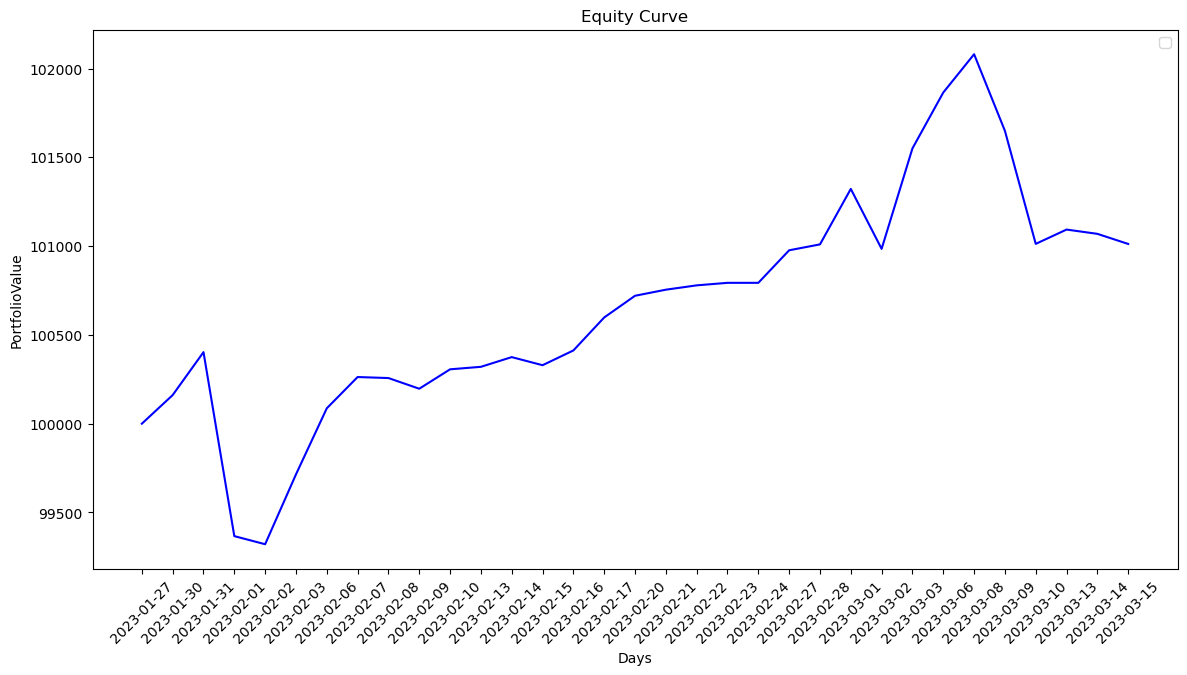

[Timestamp('2023-01-27 00:00:00'), Timestamp('2023-03-15 00:00:00')] [-100000.0, 101012.0707]
8.134097528302755
max dd -1.0772996673701352
(2023, 2)
(2023, 3)


,,FEB,MAR
Year,Change_%_Yearly,,
2023,1.012071,0.790000,0.220000


In [40]:
plvalue = []
pl = 0

for idi, row in result.iterrows():
    pval = 0
    if row["D_marker"] == "F":

        result.loc[idi, 'pl_check'] = pl + initial_equity
        result.loc[idi+1:, 'pl_check'] = np.nan

        result.loc[idi , 'units_new'] = ((result.loc[idi ,'pl_check'])/result.loc[idi, 'margin'])
        result.loc[idi+1: , 'units_new'] = np.nan
       
        result.loc[idi, index + '_qty_final'] = result.loc[idi, index + "_qty"] * result.loc[idi, 'units_new']
        result.loc[idi+1:, index + '_qty_final'] = np.nan
        
        result.loc[idi, 'plvalue_' + index] = 0

        for i in stock_list:                                                                    
            result.loc[idi, i + '_qty_final'] = result.loc[idi, i + "_qty"] * result.loc[idi, 'units_new']
            result.loc[idi+1:, i + '_qty_final'] = np.nan
            result.loc[idi, 'plvalue_' + i] = 0
        
        result = result.ffill()

        
    else:
            if row["Trade_Type"] == "SILS":
                plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_CE"] - result.loc[idi, index + "_OPT_Close_CE"])
                plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_PE"] - result.loc[idi, index + "_OPT_Close_PE"])
                pval = plvalce + plvalpe

                result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe
                
                for i in stock_list:
                    plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_CE"] - result.loc[idi-1, i + "_OPT_Close_CE"])
                    plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_PE"] - result.loc[idi-1, i + "_OPT_Close_PE"])
                    pval += plvalce + plvalpe

                    result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 
                    
            if row["Trade_Type"] == "LISS":
                plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_CE"] - result.loc[idi-1, index + "_OPT_Close_CE"])
                plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_PE"] - result.loc[idi-1, index + "_OPT_Close_PE"])
                pval = plvalce + plvalpe

                result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe
                
                for i in stock_list:
                    plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_OPT_Close_CE"] - result.loc[idi, i + "_OPT_Close_CE"])
                    plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_OPT_Close_PE"] - result.loc[idi, i + "_OPT_Close_PE"])
                    pval += plvalce + plvalpe

                    result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 
            
            pl += pval
        
        
    plvalue.append(pval)

result["Daily_PL"] = plvalue

result.to_csv(output_path+"\pl_final4.csv")

result.loc[0,'Daily_PL'] = initial_equity
result["PortfolioValue"] = result["Daily_PL"].cumsum()
result.loc[0,'Daily_PL'] = 0

display(result)

result.to_csv(output_path+"/final4.1.csv")

fig = plt.figure(figsize=(14,7))
plt.title('Equity Curve')
plt.xlabel('Days')
plt.ylabel('PortfolioValue')
plt.plot((result["BANKNIFTY_Date_CE"]).astype('str'),result['PortfolioValue'], c = 'blue')

plt.xticks(rotation=45)

plt.legend()
plt.show()



### Calculate CAGR 

df = result.copy()
from pyxirr import xirr

firstValue = round(df.loc[0, 'PortfolioValue'],4)
lastValue = round(df.loc[df.index[-1], 'PortfolioValue'],4)

firstDate = (df.loc[0, 'BANKNIFTY_Date_CE'])
lastDate = (df.loc[df.index[-1], 'BANKNIFTY_Date_CE'])

dates = [firstDate, lastDate]
amounts = [-firstValue, lastValue]
print(dates,amounts)
xirr = xirr(dates, amounts)

print(xirr*100)
### Calculate Daily Drawdown

Roll_Max = round(df['PortfolioValue'].expanding().max(), 2)
Daily_Drawdown = (round(df['PortfolioValue'], 2)/Roll_Max) - 1.0


#Roll_Max[0:50], Daily_Drawdown[0:50]

df['Daily_Drawdown'] = Daily_Drawdown * 100

print("max dd", min(df['Daily_Drawdown']))

df.to_csv(output_path + '/DailyDrawdown.csv', index=False)

### Monthly PNL Percentage 

df['BANKNIFTY_curr_exp_date_CE'] = pd.to_datetime(df['BANKNIFTY_curr_exp_date_CE'], dayfirst=True)

df['Year'] = pd.DatetimeIndex(df['BANKNIFTY_curr_exp_date_CE']).year
df['Month'] = pd.DatetimeIndex(df['BANKNIFTY_curr_exp_date_CE']).month
df.to_csv(output_path + '/df.csv', index=False)

i = 0
dfg = df.groupby(['Year', 'Month'])
for name, group in dfg:
    print(name)
    if i == 0: 
        firstValue = group['PortfolioValue'].iloc[0]
        i = 1
    else:
        firstValue = lastValue

    lastValue = group['PortfolioValue'].loc[group.index[-1]]
    change = lastValue/firstValue - 1
    df.loc[group.index, 'Change_%_Monthly'] = round(change * 100, 2)
    
i = 0
dfg = df.groupby(['Year'])
for name, group in dfg:
    #print(name)
    if i == 0: 
        firstValue = group['PortfolioValue'].iloc[0]
        i = 1
    else:
        firstValue = lastValue

    lastValue = group['PortfolioValue'].loc[group.index[-1]]
    change = lastValue/firstValue - 1
    df.loc[group.index, 'Change_%_Yearly'] = change * 100
    
df

df1 = df[['Year', 'Month', 'Change_%_Monthly', 'Change_%_Yearly']]
df1 = df1.drop_duplicates()
df1

pivotTable = df1.pivot_table(values ='Change_%_Monthly', index =['Year', 'Change_%_Yearly'],
                         columns =['Month'])
#pivotTable.columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
#                      'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
pivotTable.columns = ['FEB', 'MAR']

pivotTable.index

def _color_red_or_green(val):
    color = '#EE0000' if val < 0 else '#00EE00'
    return 'background-color: %s' % color
pivotTable.style.applymap(_color_red_or_green)




In [ ]:
display(curr_final_df)
display(next_final_df)

# Adjustments Starts Here

In [ ]:
result = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)


result1 = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

result1["Date"] = result1["BANKNIFTY_Date_CE"]

final = pd.DataFrame()
final[index + '_Date_CE'] = result1["Date"]
for i in stock_list:
    print(i)
    path  = stfolder+ '/' + i + ".csv"
    df1 = pd.read_csv(path,parse_dates = ["Date"],usecols = ["Date","Ticker","Option_Type","Strike",
                                                                    "OPT_Close",f'Delta_{delta}_Strike','EQ_Close'], dayfirst = True)

    df_ce = df1[(df1["Strike"] == df1[f'Delta_{delta}_Strike']) & (df1["Option_Type"] == "CE")].add_suffix("_CE").add_prefix("Current_")
    df_pe = df1[(df1["Strike"] == df1[f'Delta_{delta}_Strike']) & (df1["Option_Type"] == "PE")].add_suffix("_PE").add_prefix("Current_")
    
    temp = df_ce.merge(df_pe, left_on='Current_Date_CE', right_on='Current_Date_PE').drop(columns = ["Current_Option_Type_PE","Current_Option_Type_CE"])
    temp = temp.T.drop_duplicates().T
    temp = temp.add_prefix(i +"_")
    final = final.merge(temp,how='left',left_on=index + '_Date_CE', right_on= i + '_Current_Date_CE').drop(columns = [i + "_Current_Date_CE"])
#final = final.T.drop_duplicates().T
result1 = result1.merge(final, how = "left", on = index+'_Date_CE')
result1.to_csv(output_path+"/final3.1.csv")
#display(result1)


# Trigger Adjustment

In [ ]:
# t = 100
# result = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)



# print("trigger :", t)

# print("Generating trigger Signals.....")
# print("          ", datetime.datetime.now())
# result1 = pd.read_csv(output_path + "/final3.1.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

# for idi, row in result1.iterrows():
#     if row["D_marker"] == "F":

#         result1.loc[idi, index + 'total_premium'] = result1.loc[idi, index + '_OPT_Close_CE'] + result1.loc[idi, index + "_OPT_Close_PE"]

#         for i in stock_list:
#             result1.loc[idi, i + "D_marker_1"] = "F"
#             result1.loc[idi+1:, i + 'D_marker_1'] = "M"
#             result1.loc[idi, i + "D_marker_2"] = "F"
#             result1.loc[idi+1:, i + "D_marker_2"] = "M"


#             result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
#             result1.loc[idi, i + 'stop_trigger_CE'] = t*(result1.loc[idi, i + '_Current_Strike_CE'] + result1.loc[idi, i + 'total_premium'])/100
#             result1.loc[idi, i + 'stop_trigger_PE'] = t*(result1.loc[idi, i + '_Current_Strike_PE'] - result1.loc[idi, i + 'total_premium'])/100
#             result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
#             result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan

#         result1 = result1.ffill()



#     else:
#         for i in stock_list:

#             if result1.loc[idi, "D_marker"] == "L":
#                 result1.loc[idi, i + "D_marker_1"] = "L"
#                 result1.loc[idi, i + "D_marker_2"] = "L"

#             else:

#                 if result1.loc[idi, i + 'stop_trigger_CE'] <= result1.loc[idi, i + '_Current_EQ_Close_CE']:
#                     result1.loc[idi, i + "D_marker_1"] = "L"
#                     result1.loc[idi, i + "D_marker_2"] = "F"

#                     result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
#                     result1.loc[idi, i + 'stop_trigger_CE'] = result1.loc[idi, i + '_Current_Strike_CE'] + (t*(result1.loc[idi, i + 'total_premium'])/100)
#                     result1.loc[idi, i + 'stop_trigger_PE'] = result1.loc[idi, i + '_Current_Strike_PE'] - (t*(result1.loc[idi, i + 'total_premium'])/100)
#                     result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
#                     result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan


#                 if result1.loc[idi, i + 'stop_trigger_PE'] >= result1.loc[idi, i + '_Current_EQ_Close_CE']:
#                     result1.loc[idi, i + "D_marker_1"] = "L"
#                     result1.loc[idi, i + "D_marker_2"] = "F"

#                     result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
#                     result1.loc[idi, i + 'stop_trigger_CE'] = result1.loc[idi, i + '_Current_Strike_CE'] + (t*(result1.loc[idi, i + 'total_premium'])/100)
#                     result1.loc[idi, i + 'stop_trigger_PE'] = result1.loc[idi, i + '_Current_Strike_PE'] - (t*(result1.loc[idi, i + 'total_premium'])/100)
#                     result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
#                     result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan

#                 result1 = result1.ffill()


# #display(result1)      

# result1.to_csv(output_path + "/final3.2__" + str(t) + ".csv")



In [ ]:
trigger = [150]
result = pd.read_csv(output_path + "/final3.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)



for t in trigger:
    print("trigger :", t)
    
    print("Generating trigger Signals.....")
    print("          ", datetime.datetime.now())
    result1 = pd.read_csv(output_path + "/final3.1.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
    display(result1.info())
    for idi, row in result1.iterrows():
        if row["D_marker"] == "F":

            result1.loc[idi, index + 'total_premium'] = result1.loc[idi, index + '_OPT_Close_CE'] + result1.loc[idi, index + "_OPT_Close_PE"]

            for i in stock_list:
                result1.loc[idi, i + "D_marker_1"] = "F"
                result1.loc[idi+1:, i + 'D_marker_1'] = "M"
                result1.loc[idi, i + "D_marker_2"] = "F"
                result1.loc[idi+1:, i + "D_marker_2"] = "M"
                

                result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
                result1.loc[idi, i + 'stop_trigger_CE'] = result1.loc[idi, i + '_Current_Strike_CE'] + (t*(result1.loc[idi, i + 'total_premium'])/100)
                result1.loc[idi, i + 'stop_trigger_PE'] = result1.loc[idi, i + '_Current_Strike_PE'] - (t*(result1.loc[idi, i + 'total_premium'])/100)
                result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
                result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan

            result1 = result1.ffill()



        else:
            for i in stock_list:

                if result1.loc[idi, "D_marker"] == "L":
                    result1.loc[idi, i + "D_marker_1"] = "L"
                    result1.loc[idi, i + "D_marker_2"] = "L"

                else:

                    if result1.loc[idi, i + 'stop_trigger_CE'] <= result1.loc[idi, i + '_Current_EQ_Close_CE']:
                        result1.loc[idi, i + "D_marker_1"] = "L"
                        result1.loc[idi, i + "D_marker_2"] = "F"

                        result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
                        result1.loc[idi, i + 'stop_trigger_CE'] = result1.loc[idi, i + '_Current_Strike_CE'] + (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi, i + 'stop_trigger_PE'] = result1.loc[idi, i + '_Current_Strike_PE'] - (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
                        result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan


                    if result1.loc[idi, i + 'stop_trigger_PE'] >= result1.loc[idi, i + '_Current_EQ_Close_CE']:
                        result1.loc[idi, i + "D_marker_1"] = "L"
                        result1.loc[idi, i + "D_marker_2"] = "F"

                        result1.loc[idi, i + 'total_premium'] = result1.loc[idi, i + '_Current_OPT_Close_CE'] + result1.loc[idi, i + "_Current_OPT_Close_PE"]
                        result1.loc[idi, i + 'stop_trigger_CE'] = result1.loc[idi, i + '_Current_Strike_CE'] + (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi, i + 'stop_trigger_PE'] = result1.loc[idi, i + '_Current_Strike_PE'] - (t*(result1.loc[idi, i + 'total_premium'])/100)
                        result1.loc[idi+1:, i + 'stop_trigger_CE'] = np.nan
                        result1.loc[idi+1:, i + 'stop_trigger_PE'] = np.nan

                    result1 = result1.ffill()


    #display(result1)      

    result1.to_csv(output_path + "/final3.2__" + str(t) + ".csv")

    #######################################################################################################################
    
    print("Generating TradeList.....")
    print("          ", datetime.datetime.now())
    
    trades = []
    for j in stock_list:
        df = result1[(result1[j + "D_marker_1"] == "F") | (result1[j + "D_marker_1"] == "L")].reset_index()
        #display(df)

        for i in df.index[:-1]:
            if df[j + "D_marker_2"][i] == "F":
                strikes = {}
                strikes[j] = df[j+"_Current_Strike_CE"][i]
                trades.append( 
                                { 
                                  "symbol" : j,
                                  j + "_entry_date": df[index + "_Date_CE"][i],
                                  j + "_exit_date" : df[index + "_Date_CE"][i+1],
                                  "expiry_date" : df[index+"_curr_exp_date_CE"][i],
                                  "new_month_date" : df[index+"_curr_exp_date_CE"][i+1],
                                  "strike" : strikes,
                                  "marker_1" : df[j + "D_marker_1"][i],
                                  "marker_2" : df[j + "D_marker_2"][i],

                                }
                              )

    #######################################################################################################################


    df_dum = pd.DataFrame()

    df_dum['Date'] = result1['BANKNIFTY_Date_CE']

    for j in stock_list:
        print(j)
        path = stfolder + '/' + j + ".csv"
        for i in trades:
            symbol = i["symbol"]
            if j == symbol:
                #print("####################",j)
                date1 = i[j + "_entry_date"]
                date2 = i[j + "_exit_date"]
                expiry = i["expiry_date"]
                new_month_date = i["new_month_date"]
                marker_1 = i["marker_1"]
                marker_2 = i["marker_2"]
#                 print(date1)
#                 print(date2)
#                 print(i["strike"][j])

                if ((marker_1 == "F") & (marker_2 == "F")):       #new trade data from same row
                    df_dict = {}

                    df = pd.read_csv(path,parse_dates = ["Date"], dayfirst = True)

                    df = df[(df["Date"] >= date1) & (df["Date"] <= date2) & (df["Strike"] == i["strike"][j])]
                    df = pd.merge(df_dum, df, on = 'Date', how = 'left')
                    df_dict[j] = df
                    i["dataframes"] = df_dict

                elif (marker_1 == "L") & (marker_2 == "F"):     #new trade data from next row

                    df_dict = {}

                    df = pd.read_csv(path,parse_dates = ["Date"], dayfirst = True)

                    df = df[(df["Date"] > date1) & (df["Date"] <= date2) & (df["Strike"] == i["strike"][j])]
                    df = pd.merge(df_dum, df, on = 'Date', how = 'left')
                    df_dict[j] = df
                    i["dataframes"] = df_dict




    #######################################################################################################################



    result1 = pd.DataFrame()
    result1[index + "_Date_CE"] = result[index + "_Date_CE"]
    result1.to_csv(output_path + "/final3.3check.csv")
    print("CHECK final3.3check")
    for j in stock_list:
        print("j", j)
        final = pd.DataFrame()

        for trade_dict in trades:
            df_dict = trade_dict["dataframes"]

            for i in df_dict:

                    if (i != j):
                        continue

                    df1 = df_dict[i][["Date","Ticker","OPT_Close","Strike","Option_Type","IV","EQ_Close"]]
                    df_ce = df1[(df1["Option_Type"] == "CE")].add_suffix("_CE")
                    df_pe = df1[(df1["Option_Type"] == "PE")].add_suffix("_PE")
                    
                    temp = df_ce.merge(df_pe, left_on='Date_CE', right_on='Date_PE').drop(columns = ["Option_Type_PE","Option_Type_CE"])
                    temp = temp.T.drop_duplicates().T
                    temp['Date_CE'] = pd.to_datetime(temp['Date_CE'], dayfirst = True)
                    temp = temp.add_prefix(i +"_new_")
                    final = final.append(temp)
                    

        result1 = result1.merge(final,left_on=index + '_Date_CE' , right_on= j + '_new_Date_CE', how = 'left')

    result1 = result1.T.drop_duplicates().T    
    result1.to_csv(output_path + "/final3.3__" + str(t) + ".csv")
    #display(result1)    



    #######################################################################################################################



    result1 = pd.read_csv(output_path + "/final3.2__" + str(t) + ".csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
    result2 = pd.read_csv(output_path + "/final3.3__" + str(t) + ".csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)


    result = result1.merge(result2,how='left',on=index+'_Date_CE')

    result.to_csv(output_path + "/final4.csv")
    #display(result)




    #######################################################################################################################
    print("Calculating PnL.....")
    print("          ", datetime.datetime.now())

    result = pd.read_csv(output_path + "/final4.csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)

    u = result.select_dtypes(exclude=['datetime'])
    result[u.columns] = u.fillna(0)


    plvalue = []
    pl = 0
    transaction_cost = 0

    for idi, row in result.iterrows():
        pval = 0
        if row["D_marker"] == "F":
                        
            
            result.loc[idi, 'pl_check'] = pl + initial_equity
            result.loc[idi+1:, 'pl_check'] = np.nan

            result.loc[idi , 'units_new'] = ((result.loc[idi ,'pl_check'])/result.loc[idi, 'margin'])
            result.loc[idi+1: , 'units_new'] = np.nan

            result.loc[idi, index + '_qty_final'] = result.loc[idi, index + "_qty"] * result.loc[idi, 'units_new']
            result.loc[idi+1:, index + '_qty_final'] = np.nan

            result.loc[idi, 'plvalue_' + index] = 0
            
            contract_value = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_CE"] + result.loc[idi, index + "_OPT_Close_PE"])
            
            
            for i in stock_list:                                                                    
                result.loc[idi, i + '_qty_final'] = result.loc[idi, i + "_qty"] * result.loc[idi, 'units_new']
                result.loc[idi+1:, i + '_qty_final'] = np.nan
                result.loc[idi, 'plvalue_' + i] = 0
                contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_OPT_Close_CE"] + result.loc[idi, i + "_OPT_Close_PE"])

            result.loc[idi, 'transaction_cost'] = transaction_cost
            result = result.ffill()
        

        else:

                if row["Trade_Type"] == "SILS":
                    plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_CE"] - result.loc[idi, index + "_OPT_Close_CE"])
                    plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_PE"] - result.loc[idi, index + "_OPT_Close_PE"])
                    pval = plvalce + plvalpe

                    result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe

                    for i in stock_list:

                        if result.loc[idi-1,i+"D_marker_2"] == "F":

                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] - result.loc[idi-1, i + "_Current_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_PE"] - result.loc[idi-1, i + "_Current_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 

                        else:

                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] - result.loc[idi-1, i + "_new_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_PE"] - result.loc[idi-1, i + "_new_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe
                            
                        if ((result.loc[idi, i+"D_marker_1"] == "L") & (result.loc[idi, i+"D_marker_2"] == "F")):
                            
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] + result.loc[idi, i + "_new_OPT_Close_PE"])
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_Current_OPT_Close_CE"] + result.loc[idi, i + "_Current_OPT_Close_PE"])
                            
                if row["Trade_Type"] == "LISS":
                    plvalce = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_CE"] - result.loc[idi-1, index + "_OPT_Close_CE"])
                    plvalpe = result.loc[idi, index + "_qty_final"]*(result.loc[idi, index + "_OPT_Close_PE"] - result.loc[idi-1, index + "_OPT_Close_PE"])
                    pval = plvalce + plvalpe

                    result.loc[idi, 'plvalue_' + index] = plvalce + plvalpe

                    for i in stock_list:
                        if result.loc[idi-1,i+"D_marker_2"] == "F":
                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_Current_OPT_Close_CE"] - result.loc[idi, i + "_new_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_Current_OPT_Close_PE"] - result.loc[idi, i + "_new_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 

                        else:

                            plvalce = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_new_OPT_Close_CE"] - result.loc[idi, i + "_new_OPT_Close_CE"])
                            plvalpe = result.loc[idi, i + "_qty_final"]*(result.loc[idi-1, i + "_new_OPT_Close_PE"] - result.loc[idi, i + "_new_OPT_Close_PE"])
                            pval += plvalce + plvalpe

                            result.loc[idi, 'plvalue_' + i] = plvalce + plvalpe 
                        
                        if ((result.loc[idi, i+"D_marker_1"] == "L") & (result.loc[idi, i+"D_marker_2"] == "F")):
                            
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_new_OPT_Close_CE"] + result.loc[idi, i + "_new_OPT_Close_PE"])
                            contract_value += result.loc[idi, i + "_qty_final"]*(result.loc[idi, i + "_Current_OPT_Close_CE"] + result.loc[idi, i + "_Current_OPT_Close_PE"])



                pl += pval

        
        if row['D_marker'] == "L":
            
            contract_value += result.loc[idi-1, index + "_qty_final"]*(result.loc[idi-1, index + "_OPT_Close_CE"] + result.loc[idi-1, index + "_OPT_Close_PE"])
            
            for i in stock_list:                                                                    
                contract_value += result.loc[idi-1, i + "_qty_final"]*(result.loc[idi-1, i + "_OPT_Close_CE"] + result.loc[idi-1, i + "_OPT_Close_PE"])
            
            transaction_cost = contract_value*0.005
            pl = pl - transaction_cost
            result.loc[idi, 'transaction_cost'] = transaction_cost
        
        plvalue.append(pval)

    result["Daily_PL"] = plvalue

    #result.to_csv(output_path+"\pl_final4.csv")


    result.loc[0,'Daily_PL'] = initial_equity
    result["PortfolioValue"] = (result["Daily_PL"] - result["transaction_cost"]).cumsum()
    result.loc[0,'Daily_PL'] = 0

    #display(result)
    result.to_csv(output_path+"/final4.1__" + str(t) + ".csv")
    
    #######################################################################################################################



    finallist = pd.DataFrame()
    tradelist = result[ (result["D_marker"] == "F") | (result["D_marker"] == "L") ]

    if list(tradelist.iloc[[-1]]["D_marker"])[0] == "F":
        tradelist.drop(tradelist.tail(1).index,inplace=True)
    else:
        tradelist = tradelist

    tr1 = tradelist[tradelist["D_marker"]=="F"].reset_index().drop(columns = ["index"])
    tr2 = tradelist[tradelist["D_marker"]=="L"].reset_index().drop(columns = ["index"])

    #print(tr1.shape[0])
    if tr1.shape[0] == tr2.shape[0]:
        for idx in tr1.index:
            mdict = {}
            mdict["Entry_Date"] = tr1[index+ "_Date_CE"][idx]
            mdict["Exit_Date"] = tr2[index+ "_Date_CE"][idx]
            mdict["Trade_Type"] = tr1["Trade_Type"][idx]
            for i in symbols:
                for j in ["CE","PE"]:
                    mdict[i + "_Entry_Price_" + j] = tr1[i + "_OPT_Close_" + j][idx] 
                    mdict[i + "_Exit_Price_" + j] = tr2[i + "_OPT_Close_" + j][idx]
                    mdict[i + "_Qty_" + j] = tr1[i + "_qty_final"][idx]
            temp = pd.DataFrame([mdict])
            #display(temp)
            finallist = finallist.append(temp)
    else:
        print("Error, Tradelist not proper")

    finallist.reset_index().drop(columns = ["index"])





    #######################################################################################################################




    #tradelist =  pd.concat([finallist, finallist_exp], axis=1)

    tradelist = finallist

    #display(tradelist)

    #tradelist.to_csv(output_path+"/trdlist.csv")

    pl_tradelist = tradelist.copy()
    plvalue = []
    pval = 0
    for idi, row in pl_tradelist.iterrows():

        if row["Trade_Type"] == "SILS":
            pvalce = row[index + "_Qty_CE"]*(row[index + "_Entry_Price_CE"] - row[index + "_Exit_Price_CE"])
            pvalpe = row[index + "_Qty_PE"]*(row[index + "_Entry_Price_PE"] - row[index + "_Exit_Price_PE"])
            pval = pvalce + pvalpe

            for i in stock_list:
                pvalce = row[i + "_Qty_CE"]*(row[i + "_Exit_Price_CE"] - row[i + "_Entry_Price_CE"])
                pvalpe = row[i + "_Qty_PE"]*(row[i + "_Exit_Price_PE"] - row[i + "_Entry_Price_PE"])
                pval += pvalce + pvalpe    

        if row["Trade_Type"] == "LISS":
            pvalce = row[index + "_Qty_CE"]*(row[index + "_Exit_Price_CE"] - row[index + "_Entry_Price_CE"])
            pvalpe = row[index + "_Qty_PE"]*(row[index + "_Exit_Price_PE"] - row[index + "_Entry_Price_PE"])
            pval = pvalce + pvalpe

            for i in stock_list:
                pvalce = row[i + "_Qty_CE"]*(row[i + "_Entry_Price_CE"] - row[i + "_Exit_Price_CE"])
                pvalpe = row[i + "_Qty_PE"]*(row[i + "_Entry_Price_PE"] - row[i + "_Exit_Price_PE"])
                pval += pvalce + pvalpe    

        plvalue.append(pval)

    pl_tradelist['pl'] = plvalue
    pl_tradelist.to_csv(output_path+"\pl_trdlist__" + str(t) + ".csv")



    #######################################################################################################################




    ### Calculate CAGR 
    result = pd.read_csv(output_path+"/final4.1__" + str(t) + ".csv", parse_dates = ['BANKNIFTY_Date_CE'], dayfirst = True)
    df = result.copy()
    from pyxirr import xirr

    firstValue = int(df.loc[0, 'PortfolioValue'])
    lastValue = int(df.loc[df.index[-1], 'PortfolioValue'])

    firstDate = (df.loc[0, 'BANKNIFTY_Date_CE'])
    lastDate = (df.loc[df.index[-1], 'BANKNIFTY_Date_CE'])

    dates = [firstDate, lastDate]
    amounts = [-firstValue, lastValue]
    
    
    xirr = xirr(dates, amounts)

    print("xirr : ", xirr*100)
    ### Calculate Daily Drawdown

    Roll_Max = round(df['PortfolioValue'].expanding().max(), 2)
    Daily_Drawdown = (round(df['PortfolioValue'], 2)/Roll_Max) - 1.0



    df['Daily_Drawdown'] = Daily_Drawdown * 100

    print("max dd : ", min(df['Daily_Drawdown']))

    df.to_csv(output_path + '/DailyDrawdown.csv', index=False)

    ### Monthly PNL Percentage 

    df['BANKNIFTY_curr_exp_date_CE'] = pd.to_datetime(df['BANKNIFTY_curr_exp_date_CE'], dayfirst=True)

    df['Year'] = pd.DatetimeIndex(df['BANKNIFTY_curr_exp_date_CE']).year
    df['Month'] = pd.DatetimeIndex(df['BANKNIFTY_curr_exp_date_CE']).month
    df.to_csv(output_path + '/df.csv', index=False)

    i = 0
    dfg = df.groupby(['Year', 'Month'])
    for name, group in dfg:
        #print(name)
        if i == 0: 
            firstValue = group['PortfolioValue'].iloc[0]
            i = 1
        else:
            firstValue = lastValue

        lastValue = group['PortfolioValue'].loc[group.index[-1]]
        change = lastValue/firstValue - 1
        df.loc[group.index, 'Change_%_Monthly'] = round(change * 100, 2)

    i = 0
    dfg = df.groupby(['Year'])
    for name, group in dfg:
        #print(name)
        if i == 0: 
            firstValue = group['PortfolioValue'].iloc[0]
            i = 1
        else:
            firstValue = lastValue

        lastValue = group['PortfolioValue'].loc[group.index[-1]]
        change = lastValue/firstValue - 1
        df.loc[group.index, 'Change_%_Yearly'] = change * 100

    df

    df1 = df[['Year', 'Month', 'Change_%_Monthly', 'Change_%_Yearly']]
    df1 = df1.drop_duplicates()
    df1

    pivotTable = df1.pivot_table(values ='Change_%_Monthly', index =['Year', 'Change_%_Yearly'],
                             columns =['Month'])
    pivotTable.columns = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
                          'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

    pivotTable.index

    def _color_red_or_green(val):
        color = '#EE0000' if val < 0 else '#00EE00'
        return 'background-color: %s' % color
    pivotTable.style.applymap(_color_red_or_green)








In [ ]:
    def _color_red_or_green(val):
        color = '#EE0000' if val < 0 else '#00EE00'
        return 'background-color: %s' % color
    pivotTable.style.applymap(_color_red_or_green)
